In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 10000
lstm_hidden_size = 128
epochs = 20
experiment_id = (
    "classification-max_training_samples-10000-lstm_hidden_size-128-epochs-20"
)


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


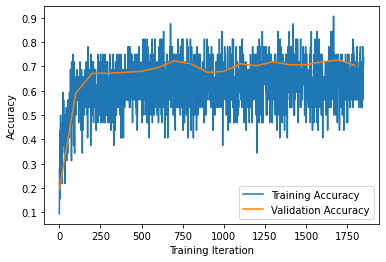

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x[:max_training_samples]),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=256
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.219 Validation Loss: 2.209 Accuracy: 0.023 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.196 Validation Loss: 2.209 Accuracy: 0.055 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.195 Validation Loss: 2.209 Accuracy: 0.062 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.195 Validation Loss: 2.209 Accuracy: 0.062 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.195 Validation Loss: 2.209 Accuracy: 0.061 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.194 Validation Loss: 2.209 Accuracy: 0.066 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.192 Validation Loss: 2.209 Accuracy: 0.073 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.192 Validation Loss: 2.209 Accuracy: 0.077 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.191 Validation Loss: 2.209 Accuracy: 0.082 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.192 Validation Loss: 2.209 Accuracy: 0.087 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.191 Validation Loss: 2.209 Accuracy: 0.098 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.189 Validation Loss: 2.209 Accuracy: 0.110 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.187 Validation Loss: 2.209 Accuracy: 0.121 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.186 Validation Loss: 2.209 Accuracy: 0.129 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.185 Validation Loss: 2.209 Accuracy: 0.141 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.185 Validation Loss: 2.209 Accuracy: 0.145 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.185 Validation Loss: 2.209 Accuracy: 0.151 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.185 Validation Loss: 2.209 Accuracy: 0.152 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.185 Validation Loss: 2.209 Accuracy: 0.149 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.184 Validation Loss: 2.209 Accuracy: 0.152 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 20 Loss: 2.182 Validation Loss: 2.209 Accuracy: 0.159 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 21 Loss: 2.181 Validation Loss: 2.209 Accuracy: 0.159 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 22 Loss: 2.181 Validation Loss: 2.209 Accuracy: 0.159 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 23 Loss: 2.179 Validation Loss: 2.209 Accuracy: 0.163 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 24 Loss: 2.177 Validation Loss: 2.209 Accuracy: 0.164 Validation Accuracy: 0.062:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 Iteration: 24 Loss: 2.177 Validation Loss: 2.209 Accuracy: 0.164 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 25 Loss: 2.176 Validation Loss: 2.209 Accuracy: 0.169 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 26 Loss: 2.176 Validation Loss: 2.209 Accuracy: 0.170 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 27 Loss: 2.174 Validation Loss: 2.209 Accuracy: 0.173 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 28 Loss: 2.171 Validation Loss: 2.209 Accuracy: 0.187 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 29 Loss: 2.169 Validation Loss: 2.209 Accuracy: 0.192 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 30 Loss: 2.168 Validation Loss: 2.209 Accuracy: 0.187 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 31 Loss: 2.167 Validation Loss: 2.209 Accuracy: 0.189 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 32 Loss: 2.167 Validation Loss: 2.209 Accuracy: 0.179 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 33 Loss: 2.166 Validation Loss: 2.209 Accuracy: 0.180 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 34 Loss: 2.164 Validation Loss: 2.209 Accuracy: 0.183 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 35 Loss: 2.162 Validation Loss: 2.209 Accuracy: 0.188 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 36 Loss: 2.161 Validation Loss: 2.209 Accuracy: 0.188 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 37 Loss: 2.159 Validation Loss: 2.209 Accuracy: 0.191 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 38 Loss: 2.156 Validation Loss: 2.209 Accuracy: 0.188 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 39 Loss: 2.155 Validation Loss: 2.209 Accuracy: 0.182 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 40 Loss: 2.154 Validation Loss: 2.209 Accuracy: 0.190 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 41 Loss: 2.153 Validation Loss: 2.209 Accuracy: 0.187 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 42 Loss: 2.150 Validation Loss: 2.209 Accuracy: 0.193 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 43 Loss: 2.150 Validation Loss: 2.209 Accuracy: 0.190 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

(10000, 10, 769)


Epoch: 0 Iteration: 44 Loss: 2.148 Validation Loss: 2.209 Accuracy: 0.191 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 45 Loss: 2.146 Validation Loss: 2.209 Accuracy: 0.186 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 46 Loss: 2.144 Validation Loss: 2.209 Accuracy: 0.183 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 47 Loss: 2.142 Validation Loss: 2.209 Accuracy: 0.183 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 48 Loss: 2.144 Validation Loss: 2.209 Accuracy: 0.178 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 49 Loss: 2.142 Validation Loss: 2.209 Accuracy: 0.189 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 50 Loss: 2.140 Validation Loss: 2.209 Accuracy: 0.187 Validation Accuracy: 0.062:  32%|███▏      | 25/79 [00:00<00:00, 241.79it/s]

Epoch: 0 Iteration: 50 Loss: 2.140 Validation Loss: 2.209 Accuracy: 0.187 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 51 Loss: 2.140 Validation Loss: 2.209 Accuracy: 0.192 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 52 Loss: 2.137 Validation Loss: 2.209 Accuracy: 0.199 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 53 Loss: 2.137 Validation Loss: 2.209 Accuracy: 0.208 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 54 Loss: 2.136 Validation Loss: 2.209 Accuracy: 0.210 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 55 Loss: 2.136 Validation Loss: 2.209 Accuracy: 0.213 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 56 Loss: 2.134 Validation Loss: 2.209 Accuracy: 0.220 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 57 Loss: 2.133 Validation Loss: 2.209 Accuracy: 0.221 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 58 Loss: 2.132 Validation Loss: 2.209 Accuracy: 0.225 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 59 Loss: 2.130 Validation Loss: 2.209 Accuracy: 0.220 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 60 Loss: 2.129 Validation Loss: 2.209 Accuracy: 0.217 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 61 Loss: 2.127 Validation Loss: 2.209 Accuracy: 0.222 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 62 Loss: 2.127 Validation Loss: 2.209 Accuracy: 0.217 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 63 Loss: 2.126 Validation Loss: 2.209 Accuracy: 0.217 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 64 Loss: 2.125 Validation Loss: 2.209 Accuracy: 0.212 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 65 Loss: 2.126 Validation Loss: 2.209 Accuracy: 0.213 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 66 Loss: 2.124 Validation Loss: 2.209 Accuracy: 0.214 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 67 Loss: 2.122 Validation Loss: 2.209 Accuracy: 0.217 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 68 Loss: 2.120 Validation Loss: 2.209 Accuracy: 0.220 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 69 Loss: 2.120 Validation Loss: 2.209 Accuracy: 0.223 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 70 Loss: 2.118 Validation Loss: 2.209 Accuracy: 0.237 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 71 Loss: 2.115 Validation Loss: 2.209 Accuracy: 0.234 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 72 Loss: 2.115 Validation Loss: 2.209 Accuracy: 0.243 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 73 Loss: 2.112 Validation Loss: 2.209 Accuracy: 0.253 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 74 Loss: 2.112 Validation Loss: 2.209 Accuracy: 0.255 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 75 Loss: 2.110 Validation Loss: 2.209 Accuracy: 0.257 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 76 Loss: 2.109 Validation Loss: 2.209 Accuracy: 0.256 Validation Accuracy: 0.062:  65%|██████▍   | 51/79 [00:00<00:00, 250.08it/s]

Epoch: 0 Iteration: 76 Loss: 2.109 Validation Loss: 2.209 Accuracy: 0.256 Validation Accuracy: 0.062:  97%|█████████▋| 77/79 [00:00<00:00, 253.17it/s]

Epoch: 0 Iteration: 77 Loss: 2.108 Validation Loss: 2.209 Accuracy: 0.262 Validation Accuracy: 0.062:  97%|█████████▋| 77/79 [00:00<00:00, 253.17it/s]

Epoch: 0 Iteration: 78 Loss: 2.106 Validation Loss: 2.209 Accuracy: 0.266 Validation Accuracy: 0.062:  97%|█████████▋| 77/79 [00:00<00:00, 253.17it/s]

Epoch: 0 Iteration: 78 Loss: 2.106 Validation Loss: 2.209 Accuracy: 0.266 Validation Accuracy: 0.062: 100%|██████████| 79/79 [00:00<00:00, 252.79it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.106 Validation Loss: 2.110 Accuracy: 0.270 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.105 Validation Loss: 2.110 Accuracy: 0.263 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.105 Validation Loss: 2.110 Accuracy: 0.271 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.103 Validation Loss: 2.110 Accuracy: 0.271 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.102 Validation Loss: 2.110 Accuracy: 0.273 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.103 Validation Loss: 2.110 Accuracy: 0.277 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.100 Validation Loss: 2.110 Accuracy: 0.281 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.099 Validation Loss: 2.110 Accuracy: 0.292 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.099 Validation Loss: 2.110 Accuracy: 0.291 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.098 Validation Loss: 2.110 Accuracy: 0.296 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.097 Validation Loss: 2.110 Accuracy: 0.298 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.098 Validation Loss: 2.110 Accuracy: 0.296 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.096 Validation Loss: 2.110 Accuracy: 0.288 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 2.094 Validation Loss: 2.110 Accuracy: 0.292 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 2.095 Validation Loss: 2.110 Accuracy: 0.289 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 2.092 Validation Loss: 2.110 Accuracy: 0.297 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.090 Validation Loss: 2.110 Accuracy: 0.305 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 2.089 Validation Loss: 2.110 Accuracy: 0.303 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 2.087 Validation Loss: 2.110 Accuracy: 0.300 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 2.088 Validation Loss: 2.110 Accuracy: 0.301 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 2.087 Validation Loss: 2.110 Accuracy: 0.298 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 2.086 Validation Loss: 2.110 Accuracy: 0.302 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 22 Loss: 2.084 Validation Loss: 2.110 Accuracy: 0.313 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 2.081 Validation Loss: 2.110 Accuracy: 0.328 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 2.078 Validation Loss: 2.110 Accuracy: 0.334 Validation Accuracy: 0.158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 2.078 Validation Loss: 2.110 Accuracy: 0.334 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 25 Loss: 2.076 Validation Loss: 2.110 Accuracy: 0.332 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 26 Loss: 2.075 Validation Loss: 2.110 Accuracy: 0.337 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 27 Loss: 2.074 Validation Loss: 2.110 Accuracy: 0.347 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 28 Loss: 2.072 Validation Loss: 2.110 Accuracy: 0.362 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 29 Loss: 2.072 Validation Loss: 2.110 Accuracy: 0.362 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 30 Loss: 2.070 Validation Loss: 2.110 Accuracy: 0.375 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 31 Loss: 2.068 Validation Loss: 2.110 Accuracy: 0.381 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 32 Loss: 2.067 Validation Loss: 2.110 Accuracy: 0.391 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 33 Loss: 2.066 Validation Loss: 2.110 Accuracy: 0.377 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 34 Loss: 2.066 Validation Loss: 2.110 Accuracy: 0.371 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 35 Loss: 2.065 Validation Loss: 2.110 Accuracy: 0.383 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 36 Loss: 2.065 Validation Loss: 2.110 Accuracy: 0.380 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 37 Loss: 2.060 Validation Loss: 2.110 Accuracy: 0.383 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 38 Loss: 2.059 Validation Loss: 2.110 Accuracy: 0.383 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 39 Loss: 2.055 Validation Loss: 2.110 Accuracy: 0.395 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 40 Loss: 2.051 Validation Loss: 2.110 Accuracy: 0.402 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 41 Loss: 2.049 Validation Loss: 2.110 Accuracy: 0.409 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 42 Loss: 2.048 Validation Loss: 2.110 Accuracy: 0.409 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 43 Loss: 2.044 Validation Loss: 2.110 Accuracy: 0.428 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 44 Loss: 2.044 Validation Loss: 2.110 Accuracy: 0.436 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 45 Loss: 2.043 Validation Loss: 2.110 Accuracy: 0.434 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 46 Loss: 2.042 Validation Loss: 2.110 Accuracy: 0.441 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 47 Loss: 2.041 Validation Loss: 2.110 Accuracy: 0.445 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 48 Loss: 2.042 Validation Loss: 2.110 Accuracy: 0.447 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 49 Loss: 2.038 Validation Loss: 2.110 Accuracy: 0.449 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 50 Loss: 2.037 Validation Loss: 2.110 Accuracy: 0.440 Validation Accuracy: 0.158:  32%|███▏      | 25/79 [00:00<00:00, 249.64it/s]

Epoch: 1 Iteration: 50 Loss: 2.037 Validation Loss: 2.110 Accuracy: 0.440 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 51 Loss: 2.036 Validation Loss: 2.110 Accuracy: 0.442 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 52 Loss: 2.035 Validation Loss: 2.110 Accuracy: 0.448 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 53 Loss: 2.030 Validation Loss: 2.110 Accuracy: 0.447 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 54 Loss: 2.026 Validation Loss: 2.110 Accuracy: 0.459 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 55 Loss: 2.024 Validation Loss: 2.110 Accuracy: 0.473 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 56 Loss: 2.022 Validation Loss: 2.110 Accuracy: 0.477 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 57 Loss: 2.024 Validation Loss: 2.110 Accuracy: 0.478 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 58 Loss: 2.022 Validation Loss: 2.110 Accuracy: 0.485 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 59 Loss: 2.021 Validation Loss: 2.110 Accuracy: 0.503 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 60 Loss: 2.023 Validation Loss: 2.110 Accuracy: 0.515 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 61 Loss: 2.021 Validation Loss: 2.110 Accuracy: 0.530 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 62 Loss: 2.020 Validation Loss: 2.110 Accuracy: 0.534 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 63 Loss: 2.023 Validation Loss: 2.110 Accuracy: 0.531 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 64 Loss: 2.021 Validation Loss: 2.110 Accuracy: 0.532 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 65 Loss: 2.020 Validation Loss: 2.110 Accuracy: 0.534 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 66 Loss: 2.019 Validation Loss: 2.110 Accuracy: 0.538 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 67 Loss: 2.020 Validation Loss: 2.110 Accuracy: 0.547 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 68 Loss: 2.019 Validation Loss: 2.110 Accuracy: 0.553 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 69 Loss: 2.018 Validation Loss: 2.110 Accuracy: 0.544 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 70 Loss: 2.016 Validation Loss: 2.110 Accuracy: 0.549 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 71 Loss: 2.018 Validation Loss: 2.110 Accuracy: 0.543 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 72 Loss: 2.015 Validation Loss: 2.110 Accuracy: 0.545 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 73 Loss: 2.018 Validation Loss: 2.110 Accuracy: 0.548 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 74 Loss: 2.016 Validation Loss: 2.110 Accuracy: 0.549 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 75 Loss: 2.016 Validation Loss: 2.110 Accuracy: 0.548 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 76 Loss: 2.016 Validation Loss: 2.110 Accuracy: 0.548 Validation Accuracy: 0.158:  65%|██████▍   | 51/79 [00:00<00:00, 252.50it/s]

Epoch: 1 Iteration: 76 Loss: 2.016 Validation Loss: 2.110 Accuracy: 0.548 Validation Accuracy: 0.158:  97%|█████████▋| 77/79 [00:00<00:00, 253.23it/s]

Epoch: 1 Iteration: 77 Loss: 2.011 Validation Loss: 2.110 Accuracy: 0.555 Validation Accuracy: 0.158:  97%|█████████▋| 77/79 [00:00<00:00, 253.23it/s]

Epoch: 1 Iteration: 78 Loss: 2.004 Validation Loss: 2.110 Accuracy: 0.581 Validation Accuracy: 0.158:  97%|█████████▋| 77/79 [00:00<00:00, 253.23it/s]

Epoch: 1 Iteration: 78 Loss: 2.004 Validation Loss: 2.110 Accuracy: 0.581 Validation Accuracy: 0.158: 100%|██████████| 79/79 [00:00<00:00, 254.06it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 2.003 Validation Loss: 2.013 Accuracy: 0.583 Validation Accuracy: 0.298:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 1.999 Validation Loss: 2.013 Accuracy: 0.585 Validation Accuracy: 0.298:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 1.998 Validation Loss: 2.013 Accuracy: 0.595 Validation Accuracy: 0.298:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 1.998 Validation Loss: 2.013 Accuracy: 0.595 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 3 Loss: 1.995 Validation Loss: 2.013 Accuracy: 0.592 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 4 Loss: 1.993 Validation Loss: 2.013 Accuracy: 0.599 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 5 Loss: 1.992 Validation Loss: 2.013 Accuracy: 0.599 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 6 Loss: 1.989 Validation Loss: 2.013 Accuracy: 0.602 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 7 Loss: 1.984 Validation Loss: 2.013 Accuracy: 0.607 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 8 Loss: 1.981 Validation Loss: 2.013 Accuracy: 0.598 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 9 Loss: 1.978 Validation Loss: 2.013 Accuracy: 0.570 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 10 Loss: 1.978 Validation Loss: 2.013 Accuracy: 0.571 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 11 Loss: 1.978 Validation Loss: 2.013 Accuracy: 0.570 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 12 Loss: 1.975 Validation Loss: 2.013 Accuracy: 0.567 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 13 Loss: 1.974 Validation Loss: 2.013 Accuracy: 0.570 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 14 Loss: 1.970 Validation Loss: 2.013 Accuracy: 0.568 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 15 Loss: 1.971 Validation Loss: 2.013 Accuracy: 0.576 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 16 Loss: 1.967 Validation Loss: 2.013 Accuracy: 0.580 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 17 Loss: 1.963 Validation Loss: 2.013 Accuracy: 0.592 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 18 Loss: 1.964 Validation Loss: 2.013 Accuracy: 0.599 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 19 Loss: 1.970 Validation Loss: 2.013 Accuracy: 0.608 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 20 Loss: 1.970 Validation Loss: 2.013 Accuracy: 0.610 Validation Accuracy: 0.298:   4%|▍         | 3/79 [00:00<00:02, 26.94it/s]

Epoch: 2 Iteration: 20 Loss: 1.970 Validation Loss: 2.013 Accuracy: 0.610 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 21 Loss: 1.971 Validation Loss: 2.013 Accuracy: 0.610 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 22 Loss: 1.971 Validation Loss: 2.013 Accuracy: 0.615 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 23 Loss: 1.971 Validation Loss: 2.013 Accuracy: 0.623 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 24 Loss: 1.972 Validation Loss: 2.013 Accuracy: 0.628 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 25 Loss: 1.973 Validation Loss: 2.013 Accuracy: 0.623 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 26 Loss: 1.973 Validation Loss: 2.013 Accuracy: 0.623 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 27 Loss: 1.973 Validation Loss: 2.013 Accuracy: 0.618 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 28 Loss: 1.972 Validation Loss: 2.013 Accuracy: 0.620 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 29 Loss: 1.968 Validation Loss: 2.013 Accuracy: 0.622 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 30 Loss: 1.964 Validation Loss: 2.013 Accuracy: 0.627 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 31 Loss: 1.965 Validation Loss: 2.013 Accuracy: 0.630 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 32 Loss: 1.964 Validation Loss: 2.013 Accuracy: 0.635 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 33 Loss: 1.964 Validation Loss: 2.013 Accuracy: 0.633 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 34 Loss: 1.962 Validation Loss: 2.013 Accuracy: 0.640 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 35 Loss: 1.964 Validation Loss: 2.013 Accuracy: 0.644 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 36 Loss: 1.964 Validation Loss: 2.013 Accuracy: 0.647 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 37 Loss: 1.966 Validation Loss: 2.013 Accuracy: 0.643 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 38 Loss: 1.965 Validation Loss: 2.013 Accuracy: 0.649 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 39 Loss: 1.966 Validation Loss: 2.013 Accuracy: 0.652 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 40 Loss: 1.965 Validation Loss: 2.013 Accuracy: 0.655 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 41 Loss: 1.960 Validation Loss: 2.013 Accuracy: 0.666 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 42 Loss: 1.957 Validation Loss: 2.013 Accuracy: 0.662 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 43 Loss: 1.957 Validation Loss: 2.013 Accuracy: 0.666 Validation Accuracy: 0.298:  27%|██▋       | 21/79 [00:00<00:00, 111.78it/s]

Epoch: 2 Iteration: 43 Loss: 1.957 Validation Loss: 2.013 Accuracy: 0.666 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 44 Loss: 1.959 Validation Loss: 2.013 Accuracy: 0.655 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 45 Loss: 1.953 Validation Loss: 2.013 Accuracy: 0.659 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 46 Loss: 1.954 Validation Loss: 2.013 Accuracy: 0.659 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 47 Loss: 1.958 Validation Loss: 2.013 Accuracy: 0.655 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 48 Loss: 1.954 Validation Loss: 2.013 Accuracy: 0.648 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 49 Loss: 1.958 Validation Loss: 2.013 Accuracy: 0.645 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 50 Loss: 1.959 Validation Loss: 2.013 Accuracy: 0.643 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 51 Loss: 1.953 Validation Loss: 2.013 Accuracy: 0.643 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 52 Loss: 1.946 Validation Loss: 2.013 Accuracy: 0.652 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 53 Loss: 1.942 Validation Loss: 2.013 Accuracy: 0.646 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 54 Loss: 1.942 Validation Loss: 2.013 Accuracy: 0.656 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 55 Loss: 1.934 Validation Loss: 2.013 Accuracy: 0.662 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 56 Loss: 1.933 Validation Loss: 2.013 Accuracy: 0.662 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 57 Loss: 1.930 Validation Loss: 2.013 Accuracy: 0.673 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 58 Loss: 1.926 Validation Loss: 2.013 Accuracy: 0.677 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 59 Loss: 1.920 Validation Loss: 2.013 Accuracy: 0.684 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 60 Loss: 1.918 Validation Loss: 2.013 Accuracy: 0.688 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 61 Loss: 1.919 Validation Loss: 2.013 Accuracy: 0.680 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 62 Loss: 1.917 Validation Loss: 2.013 Accuracy: 0.673 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 63 Loss: 1.914 Validation Loss: 2.013 Accuracy: 0.680 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 64 Loss: 1.911 Validation Loss: 2.013 Accuracy: 0.670 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 65 Loss: 1.912 Validation Loss: 2.013 Accuracy: 0.662 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 66 Loss: 1.906 Validation Loss: 2.013 Accuracy: 0.667 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 67 Loss: 1.901 Validation Loss: 2.013 Accuracy: 0.666 Validation Accuracy: 0.298:  56%|█████▌    | 44/79 [00:00<00:00, 163.23it/s]

Epoch: 2 Iteration: 67 Loss: 1.901 Validation Loss: 2.013 Accuracy: 0.666 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 68 Loss: 1.897 Validation Loss: 2.013 Accuracy: 0.671 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 69 Loss: 1.895 Validation Loss: 2.013 Accuracy: 0.663 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 70 Loss: 1.892 Validation Loss: 2.013 Accuracy: 0.666 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 71 Loss: 1.895 Validation Loss: 2.013 Accuracy: 0.670 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 72 Loss: 1.896 Validation Loss: 2.013 Accuracy: 0.677 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 73 Loss: 1.897 Validation Loss: 2.013 Accuracy: 0.670 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 74 Loss: 1.898 Validation Loss: 2.013 Accuracy: 0.677 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 75 Loss: 1.903 Validation Loss: 2.013 Accuracy: 0.681 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 76 Loss: 1.906 Validation Loss: 2.013 Accuracy: 0.670 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 77 Loss: 1.907 Validation Loss: 2.013 Accuracy: 0.670 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 78 Loss: 1.908 Validation Loss: 2.013 Accuracy: 0.671 Validation Accuracy: 0.298:  86%|████████▌ | 68/79 [00:00<00:00, 192.75it/s]

Epoch: 2 Iteration: 78 Loss: 1.908 Validation Loss: 2.013 Accuracy: 0.671 Validation Accuracy: 0.298: 100%|██████████| 79/79 [00:00<00:00, 172.21it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 1.907 Validation Loss: 1.906 Accuracy: 0.681 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 1.909 Validation Loss: 1.906 Accuracy: 0.672 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 1.909 Validation Loss: 1.906 Accuracy: 0.666 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 1.908 Validation Loss: 1.906 Accuracy: 0.659 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 1.906 Validation Loss: 1.906 Accuracy: 0.666 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 1.901 Validation Loss: 1.906 Accuracy: 0.667 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 1.895 Validation Loss: 1.906 Accuracy: 0.667 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 1.893 Validation Loss: 1.906 Accuracy: 0.677 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 1.892 Validation Loss: 1.906 Accuracy: 0.676 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 1.896 Validation Loss: 1.906 Accuracy: 0.670 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 1.892 Validation Loss: 1.906 Accuracy: 0.661 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 1.893 Validation Loss: 1.906 Accuracy: 0.662 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 1.889 Validation Loss: 1.906 Accuracy: 0.670 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 1.889 Validation Loss: 1.906 Accuracy: 0.670 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 1.883 Validation Loss: 1.906 Accuracy: 0.673 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 1.879 Validation Loss: 1.906 Accuracy: 0.673 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 1.874 Validation Loss: 1.906 Accuracy: 0.673 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 1.868 Validation Loss: 1.906 Accuracy: 0.664 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 1.871 Validation Loss: 1.906 Accuracy: 0.659 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 1.869 Validation Loss: 1.906 Accuracy: 0.648 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 1.868 Validation Loss: 1.906 Accuracy: 0.645 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 21 Loss: 1.863 Validation Loss: 1.906 Accuracy: 0.641 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 22 Loss: 1.865 Validation Loss: 1.906 Accuracy: 0.630 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 1.861 Validation Loss: 1.906 Accuracy: 0.634 Validation Accuracy: 0.391:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 1.861 Validation Loss: 1.906 Accuracy: 0.634 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 24 Loss: 1.862 Validation Loss: 1.906 Accuracy: 0.627 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 25 Loss: 1.863 Validation Loss: 1.906 Accuracy: 0.623 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 26 Loss: 1.865 Validation Loss: 1.906 Accuracy: 0.619 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 27 Loss: 1.868 Validation Loss: 1.906 Accuracy: 0.616 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 28 Loss: 1.865 Validation Loss: 1.906 Accuracy: 0.627 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 29 Loss: 1.865 Validation Loss: 1.906 Accuracy: 0.633 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 30 Loss: 1.861 Validation Loss: 1.906 Accuracy: 0.637 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 31 Loss: 1.859 Validation Loss: 1.906 Accuracy: 0.641 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 32 Loss: 1.858 Validation Loss: 1.906 Accuracy: 0.642 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 33 Loss: 1.855 Validation Loss: 1.906 Accuracy: 0.636 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 34 Loss: 1.857 Validation Loss: 1.906 Accuracy: 0.634 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 35 Loss: 1.856 Validation Loss: 1.906 Accuracy: 0.640 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 36 Loss: 1.852 Validation Loss: 1.906 Accuracy: 0.644 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 37 Loss: 1.851 Validation Loss: 1.906 Accuracy: 0.647 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 38 Loss: 1.847 Validation Loss: 1.906 Accuracy: 0.639 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 39 Loss: 1.845 Validation Loss: 1.906 Accuracy: 0.640 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 40 Loss: 1.845 Validation Loss: 1.906 Accuracy: 0.645 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 41 Loss: 1.841 Validation Loss: 1.906 Accuracy: 0.650 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 42 Loss: 1.834 Validation Loss: 1.906 Accuracy: 0.656 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 43 Loss: 1.836 Validation Loss: 1.906 Accuracy: 0.655 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 44 Loss: 1.833 Validation Loss: 1.906 Accuracy: 0.649 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 45 Loss: 1.832 Validation Loss: 1.906 Accuracy: 0.651 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 46 Loss: 1.830 Validation Loss: 1.906 Accuracy: 0.642 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 47 Loss: 1.828 Validation Loss: 1.906 Accuracy: 0.641 Validation Accuracy: 0.391:  30%|███       | 24/79 [00:00<00:00, 234.84it/s]

Epoch: 3 Iteration: 47 Loss: 1.828 Validation Loss: 1.906 Accuracy: 0.641 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 48 Loss: 1.829 Validation Loss: 1.906 Accuracy: 0.634 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 49 Loss: 1.826 Validation Loss: 1.906 Accuracy: 0.634 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 50 Loss: 1.824 Validation Loss: 1.906 Accuracy: 0.629 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 51 Loss: 1.823 Validation Loss: 1.906 Accuracy: 0.620 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 52 Loss: 1.820 Validation Loss: 1.906 Accuracy: 0.619 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 53 Loss: 1.821 Validation Loss: 1.906 Accuracy: 0.623 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 54 Loss: 1.820 Validation Loss: 1.906 Accuracy: 0.623 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 55 Loss: 1.819 Validation Loss: 1.906 Accuracy: 0.615 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 56 Loss: 1.819 Validation Loss: 1.906 Accuracy: 0.630 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 57 Loss: 1.818 Validation Loss: 1.906 Accuracy: 0.631 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 58 Loss: 1.813 Validation Loss: 1.906 Accuracy: 0.641 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 59 Loss: 1.812 Validation Loss: 1.906 Accuracy: 0.636 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 60 Loss: 1.811 Validation Loss: 1.906 Accuracy: 0.634 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 61 Loss: 1.812 Validation Loss: 1.906 Accuracy: 0.635 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 62 Loss: 1.810 Validation Loss: 1.906 Accuracy: 0.636 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 63 Loss: 1.809 Validation Loss: 1.906 Accuracy: 0.641 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 64 Loss: 1.809 Validation Loss: 1.906 Accuracy: 0.650 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 65 Loss: 1.808 Validation Loss: 1.906 Accuracy: 0.650 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 66 Loss: 1.807 Validation Loss: 1.906 Accuracy: 0.634 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 67 Loss: 1.806 Validation Loss: 1.906 Accuracy: 0.636 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 68 Loss: 1.801 Validation Loss: 1.906 Accuracy: 0.641 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 69 Loss: 1.802 Validation Loss: 1.906 Accuracy: 0.651 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 70 Loss: 1.800 Validation Loss: 1.906 Accuracy: 0.655 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 71 Loss: 1.800 Validation Loss: 1.906 Accuracy: 0.652 Validation Accuracy: 0.391:  61%|██████    | 48/79 [00:00<00:00, 236.41it/s]

Epoch: 3 Iteration: 71 Loss: 1.800 Validation Loss: 1.906 Accuracy: 0.652 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 72 Loss: 1.800 Validation Loss: 1.906 Accuracy: 0.655 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 73 Loss: 1.798 Validation Loss: 1.906 Accuracy: 0.648 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 74 Loss: 1.798 Validation Loss: 1.906 Accuracy: 0.643 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 75 Loss: 1.791 Validation Loss: 1.906 Accuracy: 0.651 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 76 Loss: 1.793 Validation Loss: 1.906 Accuracy: 0.656 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 77 Loss: 1.791 Validation Loss: 1.906 Accuracy: 0.653 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 78 Loss: 1.791 Validation Loss: 1.906 Accuracy: 0.645 Validation Accuracy: 0.391:  91%|█████████ | 72/79 [00:00<00:00, 236.84it/s]

Epoch: 3 Iteration: 78 Loss: 1.791 Validation Loss: 1.906 Accuracy: 0.645 Validation Accuracy: 0.391: 100%|██████████| 79/79 [00:00<00:00, 237.72it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 1.791 Validation Loss: 1.785 Accuracy: 0.636 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 1.789 Validation Loss: 1.785 Accuracy: 0.639 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 1.790 Validation Loss: 1.785 Accuracy: 0.647 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 1.790 Validation Loss: 1.785 Accuracy: 0.638 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.789 Validation Loss: 1.785 Accuracy: 0.628 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 1.790 Validation Loss: 1.785 Accuracy: 0.623 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 1.787 Validation Loss: 1.785 Accuracy: 0.616 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 1.782 Validation Loss: 1.785 Accuracy: 0.616 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 1.779 Validation Loss: 1.785 Accuracy: 0.618 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 1.774 Validation Loss: 1.785 Accuracy: 0.624 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 1.772 Validation Loss: 1.785 Accuracy: 0.628 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 1.770 Validation Loss: 1.785 Accuracy: 0.625 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 1.766 Validation Loss: 1.785 Accuracy: 0.625 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 1.761 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 1.759 Validation Loss: 1.785 Accuracy: 0.633 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 1.760 Validation Loss: 1.785 Accuracy: 0.634 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 1.763 Validation Loss: 1.785 Accuracy: 0.634 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 1.761 Validation Loss: 1.785 Accuracy: 0.633 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 1.762 Validation Loss: 1.785 Accuracy: 0.634 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 1.757 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 1.758 Validation Loss: 1.785 Accuracy: 0.623 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 1.763 Validation Loss: 1.785 Accuracy: 0.616 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 22 Loss: 1.761 Validation Loss: 1.785 Accuracy: 0.609 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 23 Loss: 1.758 Validation Loss: 1.785 Accuracy: 0.605 Validation Accuracy: 0.443:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Iteration: 23 Loss: 1.758 Validation Loss: 1.785 Accuracy: 0.605 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 24 Loss: 1.754 Validation Loss: 1.785 Accuracy: 0.615 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 25 Loss: 1.748 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 26 Loss: 1.747 Validation Loss: 1.785 Accuracy: 0.629 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 27 Loss: 1.748 Validation Loss: 1.785 Accuracy: 0.621 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 28 Loss: 1.747 Validation Loss: 1.785 Accuracy: 0.619 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 29 Loss: 1.747 Validation Loss: 1.785 Accuracy: 0.615 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 30 Loss: 1.744 Validation Loss: 1.785 Accuracy: 0.618 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 31 Loss: 1.747 Validation Loss: 1.785 Accuracy: 0.618 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 32 Loss: 1.744 Validation Loss: 1.785 Accuracy: 0.626 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 33 Loss: 1.747 Validation Loss: 1.785 Accuracy: 0.626 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 34 Loss: 1.748 Validation Loss: 1.785 Accuracy: 0.615 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 35 Loss: 1.740 Validation Loss: 1.785 Accuracy: 0.605 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 36 Loss: 1.740 Validation Loss: 1.785 Accuracy: 0.603 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 37 Loss: 1.743 Validation Loss: 1.785 Accuracy: 0.606 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 38 Loss: 1.737 Validation Loss: 1.785 Accuracy: 0.613 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 39 Loss: 1.733 Validation Loss: 1.785 Accuracy: 0.615 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 40 Loss: 1.725 Validation Loss: 1.785 Accuracy: 0.619 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 41 Loss: 1.718 Validation Loss: 1.785 Accuracy: 0.624 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 42 Loss: 1.716 Validation Loss: 1.785 Accuracy: 0.620 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 43 Loss: 1.713 Validation Loss: 1.785 Accuracy: 0.622 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 44 Loss: 1.712 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 45 Loss: 1.713 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 46 Loss: 1.715 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 47 Loss: 1.712 Validation Loss: 1.785 Accuracy: 0.637 Validation Accuracy: 0.443:  30%|███       | 24/79 [00:00<00:00, 235.76it/s]

Epoch: 4 Iteration: 47 Loss: 1.712 Validation Loss: 1.785 Accuracy: 0.637 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 48 Loss: 1.707 Validation Loss: 1.785 Accuracy: 0.640 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 49 Loss: 1.707 Validation Loss: 1.785 Accuracy: 0.642 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 50 Loss: 1.706 Validation Loss: 1.785 Accuracy: 0.638 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 51 Loss: 1.704 Validation Loss: 1.785 Accuracy: 0.634 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 52 Loss: 1.701 Validation Loss: 1.785 Accuracy: 0.640 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 53 Loss: 1.700 Validation Loss: 1.785 Accuracy: 0.635 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 54 Loss: 1.695 Validation Loss: 1.785 Accuracy: 0.633 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 55 Loss: 1.698 Validation Loss: 1.785 Accuracy: 0.636 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 56 Loss: 1.694 Validation Loss: 1.785 Accuracy: 0.634 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 57 Loss: 1.693 Validation Loss: 1.785 Accuracy: 0.627 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 58 Loss: 1.692 Validation Loss: 1.785 Accuracy: 0.626 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 59 Loss: 1.689 Validation Loss: 1.785 Accuracy: 0.623 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 60 Loss: 1.690 Validation Loss: 1.785 Accuracy: 0.625 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 61 Loss: 1.691 Validation Loss: 1.785 Accuracy: 0.622 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 62 Loss: 1.685 Validation Loss: 1.785 Accuracy: 0.620 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 63 Loss: 1.682 Validation Loss: 1.785 Accuracy: 0.631 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 64 Loss: 1.680 Validation Loss: 1.785 Accuracy: 0.630 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 65 Loss: 1.677 Validation Loss: 1.785 Accuracy: 0.629 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 66 Loss: 1.669 Validation Loss: 1.785 Accuracy: 0.637 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 67 Loss: 1.665 Validation Loss: 1.785 Accuracy: 0.643 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 68 Loss: 1.665 Validation Loss: 1.785 Accuracy: 0.638 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 69 Loss: 1.662 Validation Loss: 1.785 Accuracy: 0.641 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 70 Loss: 1.663 Validation Loss: 1.785 Accuracy: 0.631 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 71 Loss: 1.659 Validation Loss: 1.785 Accuracy: 0.633 Validation Accuracy: 0.443:  61%|██████    | 48/79 [00:00<00:00, 234.85it/s]

Epoch: 4 Iteration: 71 Loss: 1.659 Validation Loss: 1.785 Accuracy: 0.633 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 72 Loss: 1.655 Validation Loss: 1.785 Accuracy: 0.637 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 73 Loss: 1.653 Validation Loss: 1.785 Accuracy: 0.628 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 74 Loss: 1.653 Validation Loss: 1.785 Accuracy: 0.626 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 75 Loss: 1.649 Validation Loss: 1.785 Accuracy: 0.625 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 76 Loss: 1.643 Validation Loss: 1.785 Accuracy: 0.623 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 77 Loss: 1.638 Validation Loss: 1.785 Accuracy: 0.617 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 78 Loss: 1.637 Validation Loss: 1.785 Accuracy: 0.598 Validation Accuracy: 0.443:  91%|█████████ | 72/79 [00:00<00:00, 236.03it/s]

Epoch: 4 Iteration: 78 Loss: 1.637 Validation Loss: 1.785 Accuracy: 0.598 Validation Accuracy: 0.443: 100%|██████████| 79/79 [00:00<00:00, 237.47it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.639 Validation Loss: 1.652 Accuracy: 0.592 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.634 Validation Loss: 1.652 Accuracy: 0.611 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.629 Validation Loss: 1.652 Accuracy: 0.612 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.627 Validation Loss: 1.652 Accuracy: 0.610 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.631 Validation Loss: 1.652 Accuracy: 0.610 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 1.635 Validation Loss: 1.652 Accuracy: 0.609 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 1.635 Validation Loss: 1.652 Accuracy: 0.609 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 1.630 Validation Loss: 1.652 Accuracy: 0.607 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 1.635 Validation Loss: 1.652 Accuracy: 0.606 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 1.630 Validation Loss: 1.652 Accuracy: 0.629 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 1.630 Validation Loss: 1.652 Accuracy: 0.630 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 1.626 Validation Loss: 1.652 Accuracy: 0.621 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.629 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 1.632 Validation Loss: 1.652 Accuracy: 0.616 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 1.629 Validation Loss: 1.652 Accuracy: 0.620 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 1.626 Validation Loss: 1.652 Accuracy: 0.618 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 1.622 Validation Loss: 1.652 Accuracy: 0.621 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 1.627 Validation Loss: 1.652 Accuracy: 0.616 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.625 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 1.626 Validation Loss: 1.652 Accuracy: 0.621 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 1.626 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 1.631 Validation Loss: 1.652 Accuracy: 0.613 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 22 Loss: 1.627 Validation Loss: 1.652 Accuracy: 0.617 Validation Accuracy: 0.477:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Iteration: 22 Loss: 1.627 Validation Loss: 1.652 Accuracy: 0.617 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 23 Loss: 1.630 Validation Loss: 1.652 Accuracy: 0.620 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 24 Loss: 1.629 Validation Loss: 1.652 Accuracy: 0.612 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 25 Loss: 1.622 Validation Loss: 1.652 Accuracy: 0.619 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 26 Loss: 1.618 Validation Loss: 1.652 Accuracy: 0.618 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 27 Loss: 1.624 Validation Loss: 1.652 Accuracy: 0.617 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 28 Loss: 1.624 Validation Loss: 1.652 Accuracy: 0.605 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 29 Loss: 1.629 Validation Loss: 1.652 Accuracy: 0.602 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 30 Loss: 1.628 Validation Loss: 1.652 Accuracy: 0.602 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 31 Loss: 1.626 Validation Loss: 1.652 Accuracy: 0.615 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 32 Loss: 1.623 Validation Loss: 1.652 Accuracy: 0.615 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 33 Loss: 1.620 Validation Loss: 1.652 Accuracy: 0.608 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 34 Loss: 1.622 Validation Loss: 1.652 Accuracy: 0.613 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 35 Loss: 1.616 Validation Loss: 1.652 Accuracy: 0.613 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 36 Loss: 1.615 Validation Loss: 1.652 Accuracy: 0.610 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 37 Loss: 1.614 Validation Loss: 1.652 Accuracy: 0.613 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 38 Loss: 1.616 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 39 Loss: 1.611 Validation Loss: 1.652 Accuracy: 0.622 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 40 Loss: 1.612 Validation Loss: 1.652 Accuracy: 0.616 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 41 Loss: 1.606 Validation Loss: 1.652 Accuracy: 0.615 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 42 Loss: 1.606 Validation Loss: 1.652 Accuracy: 0.607 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 43 Loss: 1.598 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 44 Loss: 1.589 Validation Loss: 1.652 Accuracy: 0.628 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 45 Loss: 1.590 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 46 Loss: 1.591 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:  29%|██▉       | 23/79 [00:00<00:00, 228.89it/s]

Epoch: 5 Iteration: 46 Loss: 1.591 Validation Loss: 1.652 Accuracy: 0.623 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 47 Loss: 1.586 Validation Loss: 1.652 Accuracy: 0.625 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 48 Loss: 1.579 Validation Loss: 1.652 Accuracy: 0.626 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 49 Loss: 1.578 Validation Loss: 1.652 Accuracy: 0.626 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 50 Loss: 1.576 Validation Loss: 1.652 Accuracy: 0.629 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 51 Loss: 1.572 Validation Loss: 1.652 Accuracy: 0.630 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 52 Loss: 1.564 Validation Loss: 1.652 Accuracy: 0.641 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 53 Loss: 1.564 Validation Loss: 1.652 Accuracy: 0.634 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 54 Loss: 1.557 Validation Loss: 1.652 Accuracy: 0.630 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 55 Loss: 1.558 Validation Loss: 1.652 Accuracy: 0.633 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 56 Loss: 1.552 Validation Loss: 1.652 Accuracy: 0.642 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 57 Loss: 1.552 Validation Loss: 1.652 Accuracy: 0.643 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 58 Loss: 1.547 Validation Loss: 1.652 Accuracy: 0.640 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 59 Loss: 1.547 Validation Loss: 1.652 Accuracy: 0.645 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 60 Loss: 1.545 Validation Loss: 1.652 Accuracy: 0.640 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 61 Loss: 1.543 Validation Loss: 1.652 Accuracy: 0.635 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 62 Loss: 1.538 Validation Loss: 1.652 Accuracy: 0.631 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 63 Loss: 1.541 Validation Loss: 1.652 Accuracy: 0.631 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 64 Loss: 1.542 Validation Loss: 1.652 Accuracy: 0.636 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 65 Loss: 1.536 Validation Loss: 1.652 Accuracy: 0.641 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 66 Loss: 1.531 Validation Loss: 1.652 Accuracy: 0.632 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 67 Loss: 1.524 Validation Loss: 1.652 Accuracy: 0.639 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 68 Loss: 1.523 Validation Loss: 1.652 Accuracy: 0.641 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 69 Loss: 1.518 Validation Loss: 1.652 Accuracy: 0.641 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 70 Loss: 1.515 Validation Loss: 1.652 Accuracy: 0.646 Validation Accuracy: 0.477:  59%|█████▉    | 47/79 [00:00<00:00, 230.34it/s]

Epoch: 5 Iteration: 70 Loss: 1.515 Validation Loss: 1.652 Accuracy: 0.646 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 71 Loss: 1.513 Validation Loss: 1.652 Accuracy: 0.650 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 72 Loss: 1.514 Validation Loss: 1.652 Accuracy: 0.650 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 73 Loss: 1.516 Validation Loss: 1.652 Accuracy: 0.637 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 74 Loss: 1.511 Validation Loss: 1.652 Accuracy: 0.637 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 75 Loss: 1.514 Validation Loss: 1.652 Accuracy: 0.632 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 76 Loss: 1.518 Validation Loss: 1.652 Accuracy: 0.633 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 77 Loss: 1.507 Validation Loss: 1.652 Accuracy: 0.632 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 78 Loss: 1.507 Validation Loss: 1.652 Accuracy: 0.639 Validation Accuracy: 0.477:  90%|████████▉ | 71/79 [00:00<00:00, 225.99it/s]

Epoch: 5 Iteration: 78 Loss: 1.507 Validation Loss: 1.652 Accuracy: 0.639 Validation Accuracy: 0.477: 100%|██████████| 79/79 [00:00<00:00, 227.88it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 1.503 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 1.498 Validation Loss: 1.505 Accuracy: 0.637 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 1.492 Validation Loss: 1.505 Accuracy: 0.643 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 1.492 Validation Loss: 1.505 Accuracy: 0.641 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.492 Validation Loss: 1.505 Accuracy: 0.645 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 1.492 Validation Loss: 1.505 Accuracy: 0.643 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 1.492 Validation Loss: 1.505 Accuracy: 0.643 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 1.493 Validation Loss: 1.505 Accuracy: 0.641 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 1.500 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 1.503 Validation Loss: 1.505 Accuracy: 0.623 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 1.501 Validation Loss: 1.505 Accuracy: 0.630 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 1.500 Validation Loss: 1.505 Accuracy: 0.630 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 1.498 Validation Loss: 1.505 Accuracy: 0.620 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 1.498 Validation Loss: 1.505 Accuracy: 0.616 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 1.494 Validation Loss: 1.505 Accuracy: 0.617 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 1.498 Validation Loss: 1.505 Accuracy: 0.610 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 1.490 Validation Loss: 1.505 Accuracy: 0.613 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 1.485 Validation Loss: 1.505 Accuracy: 0.614 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.491 Validation Loss: 1.505 Accuracy: 0.609 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 1.484 Validation Loss: 1.505 Accuracy: 0.621 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 1.484 Validation Loss: 1.505 Accuracy: 0.616 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 21 Loss: 1.484 Validation Loss: 1.505 Accuracy: 0.609 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 1.484 Validation Loss: 1.505 Accuracy: 0.616 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 1.482 Validation Loss: 1.505 Accuracy: 0.622 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 24 Loss: 1.480 Validation Loss: 1.505 Accuracy: 0.626 Validation Accuracy: 0.501:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Iteration: 24 Loss: 1.480 Validation Loss: 1.505 Accuracy: 0.626 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 25 Loss: 1.479 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 26 Loss: 1.474 Validation Loss: 1.505 Accuracy: 0.637 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 27 Loss: 1.473 Validation Loss: 1.505 Accuracy: 0.637 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 28 Loss: 1.464 Validation Loss: 1.505 Accuracy: 0.641 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 29 Loss: 1.458 Validation Loss: 1.505 Accuracy: 0.636 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 30 Loss: 1.462 Validation Loss: 1.505 Accuracy: 0.632 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 31 Loss: 1.458 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 32 Loss: 1.460 Validation Loss: 1.505 Accuracy: 0.629 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 33 Loss: 1.461 Validation Loss: 1.505 Accuracy: 0.623 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 34 Loss: 1.452 Validation Loss: 1.505 Accuracy: 0.627 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 35 Loss: 1.452 Validation Loss: 1.505 Accuracy: 0.622 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 36 Loss: 1.455 Validation Loss: 1.505 Accuracy: 0.618 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 37 Loss: 1.456 Validation Loss: 1.505 Accuracy: 0.622 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 38 Loss: 1.454 Validation Loss: 1.505 Accuracy: 0.616 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 39 Loss: 1.450 Validation Loss: 1.505 Accuracy: 0.616 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 40 Loss: 1.444 Validation Loss: 1.505 Accuracy: 0.627 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 41 Loss: 1.442 Validation Loss: 1.505 Accuracy: 0.630 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 42 Loss: 1.443 Validation Loss: 1.505 Accuracy: 0.636 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 43 Loss: 1.442 Validation Loss: 1.505 Accuracy: 0.639 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 44 Loss: 1.440 Validation Loss: 1.505 Accuracy: 0.636 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 45 Loss: 1.436 Validation Loss: 1.505 Accuracy: 0.641 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 46 Loss: 1.442 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 47 Loss: 1.441 Validation Loss: 1.505 Accuracy: 0.623 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 48 Loss: 1.445 Validation Loss: 1.505 Accuracy: 0.627 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 49 Loss: 1.435 Validation Loss: 1.505 Accuracy: 0.637 Validation Accuracy: 0.501:  32%|███▏      | 25/79 [00:00<00:00, 245.37it/s]

Epoch: 6 Iteration: 49 Loss: 1.435 Validation Loss: 1.505 Accuracy: 0.637 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 50 Loss: 1.429 Validation Loss: 1.505 Accuracy: 0.632 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 51 Loss: 1.429 Validation Loss: 1.505 Accuracy: 0.631 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 52 Loss: 1.426 Validation Loss: 1.505 Accuracy: 0.627 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 53 Loss: 1.417 Validation Loss: 1.505 Accuracy: 0.633 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 54 Loss: 1.426 Validation Loss: 1.505 Accuracy: 0.627 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 55 Loss: 1.424 Validation Loss: 1.505 Accuracy: 0.620 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 56 Loss: 1.426 Validation Loss: 1.505 Accuracy: 0.621 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 57 Loss: 1.425 Validation Loss: 1.505 Accuracy: 0.633 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 58 Loss: 1.420 Validation Loss: 1.505 Accuracy: 0.638 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 59 Loss: 1.425 Validation Loss: 1.505 Accuracy: 0.630 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 60 Loss: 1.425 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 61 Loss: 1.420 Validation Loss: 1.505 Accuracy: 0.640 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 62 Loss: 1.417 Validation Loss: 1.505 Accuracy: 0.643 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 63 Loss: 1.417 Validation Loss: 1.505 Accuracy: 0.636 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 64 Loss: 1.410 Validation Loss: 1.505 Accuracy: 0.646 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 65 Loss: 1.409 Validation Loss: 1.505 Accuracy: 0.655 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 66 Loss: 1.405 Validation Loss: 1.505 Accuracy: 0.653 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 67 Loss: 1.397 Validation Loss: 1.505 Accuracy: 0.655 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 68 Loss: 1.391 Validation Loss: 1.505 Accuracy: 0.658 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 69 Loss: 1.390 Validation Loss: 1.505 Accuracy: 0.661 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 70 Loss: 1.386 Validation Loss: 1.505 Accuracy: 0.653 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 71 Loss: 1.381 Validation Loss: 1.505 Accuracy: 0.653 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 72 Loss: 1.382 Validation Loss: 1.505 Accuracy: 0.648 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 73 Loss: 1.385 Validation Loss: 1.505 Accuracy: 0.652 Validation Accuracy: 0.501:  63%|██████▎   | 50/79 [00:00<00:00, 231.61it/s]

Epoch: 6 Iteration: 73 Loss: 1.385 Validation Loss: 1.505 Accuracy: 0.652 Validation Accuracy: 0.501:  94%|█████████▎| 74/79 [00:00<00:00, 227.76it/s]

Epoch: 6 Iteration: 74 Loss: 1.385 Validation Loss: 1.505 Accuracy: 0.639 Validation Accuracy: 0.501:  94%|█████████▎| 74/79 [00:00<00:00, 227.76it/s]

Epoch: 6 Iteration: 75 Loss: 1.376 Validation Loss: 1.505 Accuracy: 0.642 Validation Accuracy: 0.501:  94%|█████████▎| 74/79 [00:00<00:00, 227.76it/s]

Epoch: 6 Iteration: 76 Loss: 1.375 Validation Loss: 1.505 Accuracy: 0.648 Validation Accuracy: 0.501:  94%|█████████▎| 74/79 [00:00<00:00, 227.76it/s]

Epoch: 6 Iteration: 77 Loss: 1.371 Validation Loss: 1.505 Accuracy: 0.652 Validation Accuracy: 0.501:  94%|█████████▎| 74/79 [00:00<00:00, 227.76it/s]

Epoch: 6 Iteration: 78 Loss: 1.369 Validation Loss: 1.505 Accuracy: 0.645 Validation Accuracy: 0.501:  94%|█████████▎| 74/79 [00:00<00:00, 227.76it/s]

Epoch: 6 Iteration: 78 Loss: 1.369 Validation Loss: 1.505 Accuracy: 0.645 Validation Accuracy: 0.501: 100%|██████████| 79/79 [00:00<00:00, 230.88it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 1.363 Validation Loss: 1.357 Accuracy: 0.641 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 1.362 Validation Loss: 1.357 Accuracy: 0.647 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 1.361 Validation Loss: 1.357 Accuracy: 0.648 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 1.361 Validation Loss: 1.357 Accuracy: 0.650 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.352 Validation Loss: 1.357 Accuracy: 0.654 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 1.352 Validation Loss: 1.357 Accuracy: 0.666 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 1.348 Validation Loss: 1.357 Accuracy: 0.666 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 1.352 Validation Loss: 1.357 Accuracy: 0.658 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 1.352 Validation Loss: 1.357 Accuracy: 0.655 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 1.356 Validation Loss: 1.357 Accuracy: 0.652 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 1.360 Validation Loss: 1.357 Accuracy: 0.652 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 1.366 Validation Loss: 1.357 Accuracy: 0.646 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 1.368 Validation Loss: 1.357 Accuracy: 0.636 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 1.366 Validation Loss: 1.357 Accuracy: 0.634 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 1.358 Validation Loss: 1.357 Accuracy: 0.638 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 1.349 Validation Loss: 1.357 Accuracy: 0.637 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 1.347 Validation Loss: 1.357 Accuracy: 0.632 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 1.339 Validation Loss: 1.357 Accuracy: 0.643 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 1.337 Validation Loss: 1.357 Accuracy: 0.632 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 1.345 Validation Loss: 1.357 Accuracy: 0.625 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 1.347 Validation Loss: 1.357 Accuracy: 0.616 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 1.343 Validation Loss: 1.357 Accuracy: 0.628 Validation Accuracy: 0.520:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 1.343 Validation Loss: 1.357 Accuracy: 0.628 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 22 Loss: 1.345 Validation Loss: 1.357 Accuracy: 0.631 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 23 Loss: 1.345 Validation Loss: 1.357 Accuracy: 0.637 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 24 Loss: 1.350 Validation Loss: 1.357 Accuracy: 0.628 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 25 Loss: 1.348 Validation Loss: 1.357 Accuracy: 0.631 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 26 Loss: 1.346 Validation Loss: 1.357 Accuracy: 0.638 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 27 Loss: 1.340 Validation Loss: 1.357 Accuracy: 0.633 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 28 Loss: 1.341 Validation Loss: 1.357 Accuracy: 0.639 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 29 Loss: 1.334 Validation Loss: 1.357 Accuracy: 0.652 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 30 Loss: 1.328 Validation Loss: 1.357 Accuracy: 0.659 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 31 Loss: 1.317 Validation Loss: 1.357 Accuracy: 0.658 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 32 Loss: 1.317 Validation Loss: 1.357 Accuracy: 0.657 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 33 Loss: 1.314 Validation Loss: 1.357 Accuracy: 0.655 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 34 Loss: 1.319 Validation Loss: 1.357 Accuracy: 0.652 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 35 Loss: 1.319 Validation Loss: 1.357 Accuracy: 0.649 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 36 Loss: 1.316 Validation Loss: 1.357 Accuracy: 0.646 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 37 Loss: 1.317 Validation Loss: 1.357 Accuracy: 0.650 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 38 Loss: 1.316 Validation Loss: 1.357 Accuracy: 0.650 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 39 Loss: 1.306 Validation Loss: 1.357 Accuracy: 0.648 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 40 Loss: 1.304 Validation Loss: 1.357 Accuracy: 0.645 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 41 Loss: 1.304 Validation Loss: 1.357 Accuracy: 0.643 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 42 Loss: 1.296 Validation Loss: 1.357 Accuracy: 0.652 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 43 Loss: 1.293 Validation Loss: 1.357 Accuracy: 0.654 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 44 Loss: 1.295 Validation Loss: 1.357 Accuracy: 0.649 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 45 Loss: 1.296 Validation Loss: 1.357 Accuracy: 0.648 Validation Accuracy: 0.520:  28%|██▊       | 22/79 [00:00<00:00, 212.02it/s]

Epoch: 7 Iteration: 45 Loss: 1.296 Validation Loss: 1.357 Accuracy: 0.648 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 46 Loss: 1.298 Validation Loss: 1.357 Accuracy: 0.645 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 47 Loss: 1.288 Validation Loss: 1.357 Accuracy: 0.651 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 48 Loss: 1.291 Validation Loss: 1.357 Accuracy: 0.645 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 49 Loss: 1.292 Validation Loss: 1.357 Accuracy: 0.643 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 50 Loss: 1.295 Validation Loss: 1.357 Accuracy: 0.641 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 51 Loss: 1.302 Validation Loss: 1.357 Accuracy: 0.633 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 52 Loss: 1.302 Validation Loss: 1.357 Accuracy: 0.622 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 53 Loss: 1.301 Validation Loss: 1.357 Accuracy: 0.621 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 54 Loss: 1.295 Validation Loss: 1.357 Accuracy: 0.630 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 55 Loss: 1.295 Validation Loss: 1.357 Accuracy: 0.627 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 56 Loss: 1.286 Validation Loss: 1.357 Accuracy: 0.640 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 57 Loss: 1.286 Validation Loss: 1.357 Accuracy: 0.628 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 58 Loss: 1.287 Validation Loss: 1.357 Accuracy: 0.633 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 59 Loss: 1.290 Validation Loss: 1.357 Accuracy: 0.635 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 60 Loss: 1.285 Validation Loss: 1.357 Accuracy: 0.648 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 61 Loss: 1.285 Validation Loss: 1.357 Accuracy: 0.656 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 62 Loss: 1.285 Validation Loss: 1.357 Accuracy: 0.666 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 63 Loss: 1.293 Validation Loss: 1.357 Accuracy: 0.655 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 64 Loss: 1.285 Validation Loss: 1.357 Accuracy: 0.648 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 65 Loss: 1.290 Validation Loss: 1.357 Accuracy: 0.641 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 66 Loss: 1.282 Validation Loss: 1.357 Accuracy: 0.633 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 67 Loss: 1.285 Validation Loss: 1.357 Accuracy: 0.637 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 68 Loss: 1.279 Validation Loss: 1.357 Accuracy: 0.639 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 69 Loss: 1.276 Validation Loss: 1.357 Accuracy: 0.641 Validation Accuracy: 0.520:  58%|█████▊    | 46/79 [00:00<00:00, 223.14it/s]

Epoch: 7 Iteration: 69 Loss: 1.276 Validation Loss: 1.357 Accuracy: 0.641 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 70 Loss: 1.276 Validation Loss: 1.357 Accuracy: 0.630 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 71 Loss: 1.273 Validation Loss: 1.357 Accuracy: 0.624 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 72 Loss: 1.274 Validation Loss: 1.357 Accuracy: 0.610 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 73 Loss: 1.268 Validation Loss: 1.357 Accuracy: 0.627 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 74 Loss: 1.269 Validation Loss: 1.357 Accuracy: 0.631 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 75 Loss: 1.268 Validation Loss: 1.357 Accuracy: 0.637 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 76 Loss: 1.272 Validation Loss: 1.357 Accuracy: 0.635 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 77 Loss: 1.263 Validation Loss: 1.357 Accuracy: 0.646 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 78 Loss: 1.253 Validation Loss: 1.357 Accuracy: 0.657 Validation Accuracy: 0.520:  89%|████████▊ | 70/79 [00:00<00:00, 226.57it/s]

Epoch: 7 Iteration: 78 Loss: 1.253 Validation Loss: 1.357 Accuracy: 0.657 Validation Accuracy: 0.520: 100%|██████████| 79/79 [00:00<00:00, 226.37it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 1.241 Validation Loss: 1.223 Accuracy: 0.660 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 1.247 Validation Loss: 1.223 Accuracy: 0.655 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 1.247 Validation Loss: 1.223 Accuracy: 0.657 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 1.245 Validation Loss: 1.223 Accuracy: 0.670 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.232 Validation Loss: 1.223 Accuracy: 0.668 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 1.237 Validation Loss: 1.223 Accuracy: 0.667 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 1.233 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 1.244 Validation Loss: 1.223 Accuracy: 0.660 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 1.242 Validation Loss: 1.223 Accuracy: 0.652 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 1.242 Validation Loss: 1.223 Accuracy: 0.639 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 1.243 Validation Loss: 1.223 Accuracy: 0.635 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 1.238 Validation Loss: 1.223 Accuracy: 0.643 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 1.234 Validation Loss: 1.223 Accuracy: 0.647 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 1.224 Validation Loss: 1.223 Accuracy: 0.650 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 1.228 Validation Loss: 1.223 Accuracy: 0.642 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 1.227 Validation Loss: 1.223 Accuracy: 0.648 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 1.227 Validation Loss: 1.223 Accuracy: 0.648 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 1.231 Validation Loss: 1.223 Accuracy: 0.652 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 1.233 Validation Loss: 1.223 Accuracy: 0.653 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 1.245 Validation Loss: 1.223 Accuracy: 0.648 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 1.247 Validation Loss: 1.223 Accuracy: 0.654 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 21 Loss: 1.240 Validation Loss: 1.223 Accuracy: 0.654 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 1.236 Validation Loss: 1.223 Accuracy: 0.655 Validation Accuracy: 0.535:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 1.236 Validation Loss: 1.223 Accuracy: 0.655 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 23 Loss: 1.239 Validation Loss: 1.223 Accuracy: 0.648 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 24 Loss: 1.240 Validation Loss: 1.223 Accuracy: 0.650 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 25 Loss: 1.237 Validation Loss: 1.223 Accuracy: 0.642 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 26 Loss: 1.229 Validation Loss: 1.223 Accuracy: 0.648 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 27 Loss: 1.221 Validation Loss: 1.223 Accuracy: 0.651 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 28 Loss: 1.218 Validation Loss: 1.223 Accuracy: 0.651 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 29 Loss: 1.215 Validation Loss: 1.223 Accuracy: 0.658 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 30 Loss: 1.206 Validation Loss: 1.223 Accuracy: 0.659 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 31 Loss: 1.210 Validation Loss: 1.223 Accuracy: 0.657 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 32 Loss: 1.210 Validation Loss: 1.223 Accuracy: 0.655 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 33 Loss: 1.215 Validation Loss: 1.223 Accuracy: 0.647 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 34 Loss: 1.214 Validation Loss: 1.223 Accuracy: 0.647 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 35 Loss: 1.208 Validation Loss: 1.223 Accuracy: 0.658 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 36 Loss: 1.211 Validation Loss: 1.223 Accuracy: 0.649 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 37 Loss: 1.207 Validation Loss: 1.223 Accuracy: 0.651 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 38 Loss: 1.209 Validation Loss: 1.223 Accuracy: 0.650 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 39 Loss: 1.197 Validation Loss: 1.223 Accuracy: 0.655 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 40 Loss: 1.202 Validation Loss: 1.223 Accuracy: 0.647 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 41 Loss: 1.196 Validation Loss: 1.223 Accuracy: 0.653 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 42 Loss: 1.196 Validation Loss: 1.223 Accuracy: 0.653 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 43 Loss: 1.192 Validation Loss: 1.223 Accuracy: 0.664 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 44 Loss: 1.188 Validation Loss: 1.223 Accuracy: 0.667 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 45 Loss: 1.182 Validation Loss: 1.223 Accuracy: 0.662 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 46 Loss: 1.186 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:  29%|██▉       | 23/79 [00:00<00:00, 229.02it/s]

Epoch: 8 Iteration: 46 Loss: 1.186 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 47 Loss: 1.187 Validation Loss: 1.223 Accuracy: 0.664 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 48 Loss: 1.188 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 49 Loss: 1.186 Validation Loss: 1.223 Accuracy: 0.661 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 50 Loss: 1.191 Validation Loss: 1.223 Accuracy: 0.660 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 51 Loss: 1.180 Validation Loss: 1.223 Accuracy: 0.662 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 52 Loss: 1.175 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 53 Loss: 1.168 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 54 Loss: 1.165 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 55 Loss: 1.171 Validation Loss: 1.223 Accuracy: 0.663 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 56 Loss: 1.162 Validation Loss: 1.223 Accuracy: 0.662 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 57 Loss: 1.169 Validation Loss: 1.223 Accuracy: 0.655 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 58 Loss: 1.169 Validation Loss: 1.223 Accuracy: 0.652 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 59 Loss: 1.178 Validation Loss: 1.223 Accuracy: 0.645 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 60 Loss: 1.170 Validation Loss: 1.223 Accuracy: 0.652 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 61 Loss: 1.172 Validation Loss: 1.223 Accuracy: 0.648 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 62 Loss: 1.174 Validation Loss: 1.223 Accuracy: 0.637 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 63 Loss: 1.175 Validation Loss: 1.223 Accuracy: 0.635 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 64 Loss: 1.170 Validation Loss: 1.223 Accuracy: 0.639 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 65 Loss: 1.170 Validation Loss: 1.223 Accuracy: 0.640 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 66 Loss: 1.168 Validation Loss: 1.223 Accuracy: 0.644 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 67 Loss: 1.160 Validation Loss: 1.223 Accuracy: 0.657 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 68 Loss: 1.164 Validation Loss: 1.223 Accuracy: 0.653 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 69 Loss: 1.168 Validation Loss: 1.223 Accuracy: 0.660 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 70 Loss: 1.166 Validation Loss: 1.223 Accuracy: 0.657 Validation Accuracy: 0.535:  59%|█████▉    | 47/79 [00:00<00:00, 230.17it/s]

Epoch: 8 Iteration: 70 Loss: 1.166 Validation Loss: 1.223 Accuracy: 0.657 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 71 Loss: 1.162 Validation Loss: 1.223 Accuracy: 0.666 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 72 Loss: 1.163 Validation Loss: 1.223 Accuracy: 0.675 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 73 Loss: 1.164 Validation Loss: 1.223 Accuracy: 0.678 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 74 Loss: 1.159 Validation Loss: 1.223 Accuracy: 0.677 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 75 Loss: 1.154 Validation Loss: 1.223 Accuracy: 0.681 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 76 Loss: 1.144 Validation Loss: 1.223 Accuracy: 0.688 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 77 Loss: 1.133 Validation Loss: 1.223 Accuracy: 0.686 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 78 Loss: 1.127 Validation Loss: 1.223 Accuracy: 0.695 Validation Accuracy: 0.535:  90%|████████▉ | 71/79 [00:00<00:00, 230.65it/s]

Epoch: 8 Iteration: 78 Loss: 1.127 Validation Loss: 1.223 Accuracy: 0.695 Validation Accuracy: 0.535: 100%|██████████| 79/79 [00:00<00:00, 231.96it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.113 Validation Loss: 1.117 Accuracy: 0.705 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.117 Validation Loss: 1.117 Accuracy: 0.704 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.118 Validation Loss: 1.117 Accuracy: 0.693 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.110 Validation Loss: 1.117 Accuracy: 0.695 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.114 Validation Loss: 1.117 Accuracy: 0.691 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 1.118 Validation Loss: 1.117 Accuracy: 0.688 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.122 Validation Loss: 1.117 Accuracy: 0.682 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 1.121 Validation Loss: 1.117 Accuracy: 0.672 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 1.125 Validation Loss: 1.117 Accuracy: 0.667 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 1.115 Validation Loss: 1.117 Accuracy: 0.670 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 1.113 Validation Loss: 1.117 Accuracy: 0.659 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 1.117 Validation Loss: 1.117 Accuracy: 0.655 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 1.122 Validation Loss: 1.117 Accuracy: 0.658 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 1.128 Validation Loss: 1.117 Accuracy: 0.646 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 1.124 Validation Loss: 1.117 Accuracy: 0.650 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 1.123 Validation Loss: 1.117 Accuracy: 0.650 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 1.122 Validation Loss: 1.117 Accuracy: 0.657 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 1.131 Validation Loss: 1.117 Accuracy: 0.661 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 1.126 Validation Loss: 1.117 Accuracy: 0.675 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 1.127 Validation Loss: 1.117 Accuracy: 0.673 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 1.128 Validation Loss: 1.117 Accuracy: 0.680 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 1.123 Validation Loss: 1.117 Accuracy: 0.686 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 22 Loss: 1.126 Validation Loss: 1.117 Accuracy: 0.682 Validation Accuracy: 0.548:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Iteration: 22 Loss: 1.126 Validation Loss: 1.117 Accuracy: 0.682 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 23 Loss: 1.127 Validation Loss: 1.117 Accuracy: 0.692 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 24 Loss: 1.121 Validation Loss: 1.117 Accuracy: 0.690 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 25 Loss: 1.112 Validation Loss: 1.117 Accuracy: 0.698 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 26 Loss: 1.108 Validation Loss: 1.117 Accuracy: 0.695 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 27 Loss: 1.104 Validation Loss: 1.117 Accuracy: 0.695 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 28 Loss: 1.106 Validation Loss: 1.117 Accuracy: 0.679 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 29 Loss: 1.107 Validation Loss: 1.117 Accuracy: 0.680 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 30 Loss: 1.107 Validation Loss: 1.117 Accuracy: 0.672 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 31 Loss: 1.101 Validation Loss: 1.117 Accuracy: 0.668 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 32 Loss: 1.102 Validation Loss: 1.117 Accuracy: 0.673 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 33 Loss: 1.095 Validation Loss: 1.117 Accuracy: 0.676 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 34 Loss: 1.093 Validation Loss: 1.117 Accuracy: 0.677 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 35 Loss: 1.092 Validation Loss: 1.117 Accuracy: 0.673 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 36 Loss: 1.097 Validation Loss: 1.117 Accuracy: 0.665 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 37 Loss: 1.087 Validation Loss: 1.117 Accuracy: 0.672 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 38 Loss: 1.102 Validation Loss: 1.117 Accuracy: 0.668 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 39 Loss: 1.099 Validation Loss: 1.117 Accuracy: 0.669 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 40 Loss: 1.097 Validation Loss: 1.117 Accuracy: 0.677 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 41 Loss: 1.096 Validation Loss: 1.117 Accuracy: 0.681 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 42 Loss: 1.094 Validation Loss: 1.117 Accuracy: 0.677 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 43 Loss: 1.091 Validation Loss: 1.117 Accuracy: 0.673 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 44 Loss: 1.090 Validation Loss: 1.117 Accuracy: 0.677 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 45 Loss: 1.099 Validation Loss: 1.117 Accuracy: 0.670 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 46 Loss: 1.095 Validation Loss: 1.117 Accuracy: 0.679 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 47 Loss: 1.101 Validation Loss: 1.117 Accuracy: 0.666 Validation Accuracy: 0.548:  29%|██▉       | 23/79 [00:00<00:00, 228.62it/s]

Epoch: 9 Iteration: 47 Loss: 1.101 Validation Loss: 1.117 Accuracy: 0.666 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 48 Loss: 1.093 Validation Loss: 1.117 Accuracy: 0.676 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 49 Loss: 1.094 Validation Loss: 1.117 Accuracy: 0.672 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 50 Loss: 1.096 Validation Loss: 1.117 Accuracy: 0.662 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 51 Loss: 1.096 Validation Loss: 1.117 Accuracy: 0.662 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 52 Loss: 1.098 Validation Loss: 1.117 Accuracy: 0.659 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 53 Loss: 1.103 Validation Loss: 1.117 Accuracy: 0.655 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 54 Loss: 1.103 Validation Loss: 1.117 Accuracy: 0.656 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 55 Loss: 1.102 Validation Loss: 1.117 Accuracy: 0.665 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 56 Loss: 1.099 Validation Loss: 1.117 Accuracy: 0.663 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 57 Loss: 1.106 Validation Loss: 1.117 Accuracy: 0.671 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 58 Loss: 1.090 Validation Loss: 1.117 Accuracy: 0.674 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 59 Loss: 1.096 Validation Loss: 1.117 Accuracy: 0.669 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 60 Loss: 1.098 Validation Loss: 1.117 Accuracy: 0.676 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 61 Loss: 1.105 Validation Loss: 1.117 Accuracy: 0.668 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 62 Loss: 1.109 Validation Loss: 1.117 Accuracy: 0.667 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 63 Loss: 1.112 Validation Loss: 1.117 Accuracy: 0.671 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 64 Loss: 1.114 Validation Loss: 1.117 Accuracy: 0.665 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 65 Loss: 1.110 Validation Loss: 1.117 Accuracy: 0.657 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 66 Loss: 1.115 Validation Loss: 1.117 Accuracy: 0.655 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 67 Loss: 1.107 Validation Loss: 1.117 Accuracy: 0.657 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 68 Loss: 1.113 Validation Loss: 1.117 Accuracy: 0.651 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 69 Loss: 1.106 Validation Loss: 1.117 Accuracy: 0.664 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 70 Loss: 1.097 Validation Loss: 1.117 Accuracy: 0.662 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 71 Loss: 1.096 Validation Loss: 1.117 Accuracy: 0.666 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 72 Loss: 1.085 Validation Loss: 1.117 Accuracy: 0.680 Validation Accuracy: 0.548:  61%|██████    | 48/79 [00:00<00:00, 235.58it/s]

Epoch: 9 Iteration: 72 Loss: 1.085 Validation Loss: 1.117 Accuracy: 0.680 Validation Accuracy: 0.548:  92%|█████████▏| 73/79 [00:00<00:00, 237.83it/s]

Epoch: 9 Iteration: 73 Loss: 1.076 Validation Loss: 1.117 Accuracy: 0.687 Validation Accuracy: 0.548:  92%|█████████▏| 73/79 [00:00<00:00, 237.83it/s]

Epoch: 9 Iteration: 74 Loss: 1.073 Validation Loss: 1.117 Accuracy: 0.694 Validation Accuracy: 0.548:  92%|█████████▏| 73/79 [00:00<00:00, 237.83it/s]

Epoch: 9 Iteration: 75 Loss: 1.077 Validation Loss: 1.117 Accuracy: 0.695 Validation Accuracy: 0.548:  92%|█████████▏| 73/79 [00:00<00:00, 237.83it/s]

Epoch: 9 Iteration: 76 Loss: 1.071 Validation Loss: 1.117 Accuracy: 0.702 Validation Accuracy: 0.548:  92%|█████████▏| 73/79 [00:00<00:00, 237.83it/s]

Epoch: 9 Iteration: 77 Loss: 1.066 Validation Loss: 1.117 Accuracy: 0.701 Validation Accuracy: 0.548:  92%|█████████▏| 73/79 [00:00<00:00, 237.83it/s]

Epoch: 9 Iteration: 78 Loss: 1.070 Validation Loss: 1.117 Accuracy: 0.711 Validation Accuracy: 0.548:  92%|█████████▏| 73/79 [00:00<00:00, 237.83it/s]

Epoch: 9 Iteration: 78 Loss: 1.070 Validation Loss: 1.117 Accuracy: 0.711 Validation Accuracy: 0.548: 100%|██████████| 79/79 [00:00<00:00, 238.63it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 1.064 Validation Loss: 1.039 Accuracy: 0.703 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 1.062 Validation Loss: 1.039 Accuracy: 0.707 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 1.059 Validation Loss: 1.039 Accuracy: 0.709 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 1.052 Validation Loss: 1.039 Accuracy: 0.698 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.048 Validation Loss: 1.039 Accuracy: 0.696 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 1.048 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 1.046 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 1.045 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 1.046 Validation Loss: 1.039 Accuracy: 0.682 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 1.036 Validation Loss: 1.039 Accuracy: 0.680 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 1.039 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 1.037 Validation Loss: 1.039 Accuracy: 0.685 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.039 Validation Loss: 1.039 Accuracy: 0.679 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 1.042 Validation Loss: 1.039 Accuracy: 0.686 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 1.051 Validation Loss: 1.039 Accuracy: 0.677 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 1.047 Validation Loss: 1.039 Accuracy: 0.681 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 1.044 Validation Loss: 1.039 Accuracy: 0.683 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 1.045 Validation Loss: 1.039 Accuracy: 0.690 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.046 Validation Loss: 1.039 Accuracy: 0.687 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 1.042 Validation Loss: 1.039 Accuracy: 0.685 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 1.042 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 1.043 Validation Loss: 1.039 Accuracy: 0.683 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 1.037 Validation Loss: 1.039 Accuracy: 0.692 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 23 Loss: 1.031 Validation Loss: 1.039 Accuracy: 0.694 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 24 Loss: 1.034 Validation Loss: 1.039 Accuracy: 0.699 Validation Accuracy: 0.610:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 Iteration: 24 Loss: 1.034 Validation Loss: 1.039 Accuracy: 0.699 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 25 Loss: 1.026 Validation Loss: 1.039 Accuracy: 0.699 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 26 Loss: 1.025 Validation Loss: 1.039 Accuracy: 0.698 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 27 Loss: 1.024 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 28 Loss: 1.026 Validation Loss: 1.039 Accuracy: 0.693 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 29 Loss: 1.030 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 30 Loss: 1.027 Validation Loss: 1.039 Accuracy: 0.694 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 31 Loss: 1.033 Validation Loss: 1.039 Accuracy: 0.689 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 32 Loss: 1.022 Validation Loss: 1.039 Accuracy: 0.693 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 33 Loss: 1.025 Validation Loss: 1.039 Accuracy: 0.688 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 34 Loss: 1.016 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 35 Loss: 1.015 Validation Loss: 1.039 Accuracy: 0.692 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 36 Loss: 1.010 Validation Loss: 1.039 Accuracy: 0.702 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 37 Loss: 1.016 Validation Loss: 1.039 Accuracy: 0.700 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 38 Loss: 1.023 Validation Loss: 1.039 Accuracy: 0.695 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 39 Loss: 1.021 Validation Loss: 1.039 Accuracy: 0.698 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 40 Loss: 1.026 Validation Loss: 1.039 Accuracy: 0.689 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 41 Loss: 1.034 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 42 Loss: 1.030 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 43 Loss: 1.034 Validation Loss: 1.039 Accuracy: 0.686 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 44 Loss: 1.029 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 45 Loss: 1.030 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 46 Loss: 1.036 Validation Loss: 1.039 Accuracy: 0.677 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 47 Loss: 1.034 Validation Loss: 1.039 Accuracy: 0.681 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 48 Loss: 1.028 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 49 Loss: 1.026 Validation Loss: 1.039 Accuracy: 0.688 Validation Accuracy: 0.610:  32%|███▏      | 25/79 [00:00<00:00, 241.71it/s]

Epoch: 10 Iteration: 49 Loss: 1.026 Validation Loss: 1.039 Accuracy: 0.688 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 50 Loss: 1.031 Validation Loss: 1.039 Accuracy: 0.694 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 51 Loss: 1.025 Validation Loss: 1.039 Accuracy: 0.702 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 52 Loss: 1.036 Validation Loss: 1.039 Accuracy: 0.695 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 53 Loss: 1.034 Validation Loss: 1.039 Accuracy: 0.695 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 54 Loss: 1.038 Validation Loss: 1.039 Accuracy: 0.690 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 55 Loss: 1.036 Validation Loss: 1.039 Accuracy: 0.691 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 56 Loss: 1.040 Validation Loss: 1.039 Accuracy: 0.695 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 57 Loss: 1.035 Validation Loss: 1.039 Accuracy: 0.696 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 58 Loss: 1.027 Validation Loss: 1.039 Accuracy: 0.695 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 59 Loss: 1.030 Validation Loss: 1.039 Accuracy: 0.695 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 60 Loss: 1.019 Validation Loss: 1.039 Accuracy: 0.702 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 61 Loss: 1.014 Validation Loss: 1.039 Accuracy: 0.699 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 62 Loss: 1.019 Validation Loss: 1.039 Accuracy: 0.700 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 63 Loss: 1.013 Validation Loss: 1.039 Accuracy: 0.700 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 64 Loss: 1.015 Validation Loss: 1.039 Accuracy: 0.699 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 65 Loss: 1.019 Validation Loss: 1.039 Accuracy: 0.693 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 66 Loss: 1.009 Validation Loss: 1.039 Accuracy: 0.698 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 67 Loss: 1.013 Validation Loss: 1.039 Accuracy: 0.694 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 68 Loss: 1.024 Validation Loss: 1.039 Accuracy: 0.685 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 69 Loss: 1.023 Validation Loss: 1.039 Accuracy: 0.687 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 70 Loss: 1.029 Validation Loss: 1.039 Accuracy: 0.675 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 71 Loss: 1.025 Validation Loss: 1.039 Accuracy: 0.682 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 72 Loss: 1.024 Validation Loss: 1.039 Accuracy: 0.680 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 73 Loss: 1.021 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 74 Loss: 1.026 Validation Loss: 1.039 Accuracy: 0.680 Validation Accuracy: 0.610:  63%|██████▎   | 50/79 [00:00<00:00, 241.43it/s]

Epoch: 10 Iteration: 74 Loss: 1.026 Validation Loss: 1.039 Accuracy: 0.680 Validation Accuracy: 0.610:  95%|█████████▍| 75/79 [00:00<00:00, 241.22it/s]

Epoch: 10 Iteration: 75 Loss: 1.027 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:  95%|█████████▍| 75/79 [00:00<00:00, 241.22it/s]

Epoch: 10 Iteration: 76 Loss: 1.025 Validation Loss: 1.039 Accuracy: 0.684 Validation Accuracy: 0.610:  95%|█████████▍| 75/79 [00:00<00:00, 241.22it/s]

Epoch: 10 Iteration: 77 Loss: 1.025 Validation Loss: 1.039 Accuracy: 0.687 Validation Accuracy: 0.610:  95%|█████████▍| 75/79 [00:00<00:00, 241.22it/s]

Epoch: 10 Iteration: 78 Loss: 1.031 Validation Loss: 1.039 Accuracy: 0.692 Validation Accuracy: 0.610:  95%|█████████▍| 75/79 [00:00<00:00, 241.22it/s]

Epoch: 10 Iteration: 78 Loss: 1.031 Validation Loss: 1.039 Accuracy: 0.692 Validation Accuracy: 0.610: 100%|██████████| 79/79 [00:00<00:00, 242.80it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 1.033 Validation Loss: 0.979 Accuracy: 0.689 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 1.038 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.694 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 1.042 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 1.042 Validation Loss: 0.979 Accuracy: 0.690 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 1.037 Validation Loss: 0.979 Accuracy: 0.700 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 1.040 Validation Loss: 0.979 Accuracy: 0.694 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 1.033 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 1.025 Validation Loss: 0.979 Accuracy: 0.706 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 1.016 Validation Loss: 0.979 Accuracy: 0.706 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 1.009 Validation Loss: 0.979 Accuracy: 0.715 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.996 Validation Loss: 0.979 Accuracy: 0.717 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.992 Validation Loss: 0.979 Accuracy: 0.727 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.984 Validation Loss: 0.979 Accuracy: 0.733 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.989 Validation Loss: 0.979 Accuracy: 0.726 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.978 Validation Loss: 0.979 Accuracy: 0.725 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.981 Validation Loss: 0.979 Accuracy: 0.729 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.984 Validation Loss: 0.979 Accuracy: 0.716 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.984 Validation Loss: 0.979 Accuracy: 0.716 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.978 Validation Loss: 0.979 Accuracy: 0.716 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.974 Validation Loss: 0.979 Accuracy: 0.709 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.977 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 0.980 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 23 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.683 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 24 Loss: 0.980 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.653:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 Iteration: 24 Loss: 0.980 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 25 Loss: 0.987 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 26 Loss: 0.983 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 27 Loss: 0.986 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 28 Loss: 0.984 Validation Loss: 0.979 Accuracy: 0.683 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 29 Loss: 0.983 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 30 Loss: 0.992 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 31 Loss: 1.001 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 32 Loss: 1.002 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 33 Loss: 1.002 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 34 Loss: 0.996 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 35 Loss: 1.001 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 36 Loss: 1.007 Validation Loss: 0.979 Accuracy: 0.697 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 37 Loss: 1.001 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 38 Loss: 0.992 Validation Loss: 0.979 Accuracy: 0.700 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 39 Loss: 0.992 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 40 Loss: 0.993 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 41 Loss: 0.987 Validation Loss: 0.979 Accuracy: 0.705 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 42 Loss: 0.978 Validation Loss: 0.979 Accuracy: 0.701 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 43 Loss: 0.971 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 44 Loss: 0.967 Validation Loss: 0.979 Accuracy: 0.701 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 45 Loss: 0.961 Validation Loss: 0.979 Accuracy: 0.707 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 46 Loss: 0.961 Validation Loss: 0.979 Accuracy: 0.707 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 47 Loss: 0.960 Validation Loss: 0.979 Accuracy: 0.712 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 48 Loss: 0.964 Validation Loss: 0.979 Accuracy: 0.707 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 49 Loss: 0.965 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.653:  32%|███▏      | 25/79 [00:00<00:00, 243.68it/s]

Epoch: 11 Iteration: 49 Loss: 0.965 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 50 Loss: 0.959 Validation Loss: 0.979 Accuracy: 0.715 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 51 Loss: 0.967 Validation Loss: 0.979 Accuracy: 0.700 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 52 Loss: 0.972 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 53 Loss: 0.973 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 54 Loss: 0.973 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 55 Loss: 0.973 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 56 Loss: 0.971 Validation Loss: 0.979 Accuracy: 0.689 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 57 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 58 Loss: 0.984 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 59 Loss: 0.990 Validation Loss: 0.979 Accuracy: 0.670 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 60 Loss: 0.988 Validation Loss: 0.979 Accuracy: 0.666 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 61 Loss: 1.000 Validation Loss: 0.979 Accuracy: 0.668 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 62 Loss: 0.999 Validation Loss: 0.979 Accuracy: 0.671 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 63 Loss: 1.003 Validation Loss: 0.979 Accuracy: 0.672 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 64 Loss: 1.001 Validation Loss: 0.979 Accuracy: 0.675 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 65 Loss: 0.999 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 66 Loss: 0.996 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 67 Loss: 0.999 Validation Loss: 0.979 Accuracy: 0.689 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 68 Loss: 0.992 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 69 Loss: 0.993 Validation Loss: 0.979 Accuracy: 0.703 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 70 Loss: 0.995 Validation Loss: 0.979 Accuracy: 0.709 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 71 Loss: 0.977 Validation Loss: 0.979 Accuracy: 0.725 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 72 Loss: 0.976 Validation Loss: 0.979 Accuracy: 0.725 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 73 Loss: 0.977 Validation Loss: 0.979 Accuracy: 0.724 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 74 Loss: 0.980 Validation Loss: 0.979 Accuracy: 0.717 Validation Accuracy: 0.653:  63%|██████▎   | 50/79 [00:00<00:00, 242.78it/s]

Epoch: 11 Iteration: 74 Loss: 0.980 Validation Loss: 0.979 Accuracy: 0.717 Validation Accuracy: 0.653:  95%|█████████▍| 75/79 [00:00<00:00, 239.64it/s]

Epoch: 11 Iteration: 75 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.715 Validation Accuracy: 0.653:  95%|█████████▍| 75/79 [00:00<00:00, 239.64it/s]

Epoch: 11 Iteration: 76 Loss: 0.969 Validation Loss: 0.979 Accuracy: 0.717 Validation Accuracy: 0.653:  95%|█████████▍| 75/79 [00:00<00:00, 239.64it/s]

Epoch: 11 Iteration: 77 Loss: 0.964 Validation Loss: 0.979 Accuracy: 0.719 Validation Accuracy: 0.653:  95%|█████████▍| 75/79 [00:00<00:00, 239.64it/s]

Epoch: 11 Iteration: 78 Loss: 0.948 Validation Loss: 0.979 Accuracy: 0.723 Validation Accuracy: 0.653:  95%|█████████▍| 75/79 [00:00<00:00, 239.64it/s]

Epoch: 11 Iteration: 78 Loss: 0.948 Validation Loss: 0.979 Accuracy: 0.723 Validation Accuracy: 0.653: 100%|██████████| 79/79 [00:00<00:00, 241.62it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.939 Validation Loss: 0.933 Accuracy: 0.730 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.935 Validation Loss: 0.933 Accuracy: 0.729 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.923 Validation Loss: 0.933 Accuracy: 0.726 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.934 Validation Loss: 0.933 Accuracy: 0.711 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.939 Validation Loss: 0.933 Accuracy: 0.705 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.945 Validation Loss: 0.933 Accuracy: 0.705 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.947 Validation Loss: 0.933 Accuracy: 0.706 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.942 Validation Loss: 0.933 Accuracy: 0.712 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.945 Validation Loss: 0.933 Accuracy: 0.709 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.952 Validation Loss: 0.933 Accuracy: 0.694 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.955 Validation Loss: 0.933 Accuracy: 0.686 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.950 Validation Loss: 0.933 Accuracy: 0.686 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.956 Validation Loss: 0.933 Accuracy: 0.683 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.953 Validation Loss: 0.933 Accuracy: 0.697 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.947 Validation Loss: 0.933 Accuracy: 0.708 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.946 Validation Loss: 0.933 Accuracy: 0.709 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.938 Validation Loss: 0.933 Accuracy: 0.713 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.937 Validation Loss: 0.933 Accuracy: 0.708 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.938 Validation Loss: 0.933 Accuracy: 0.708 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.953 Validation Loss: 0.933 Accuracy: 0.713 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.952 Validation Loss: 0.933 Accuracy: 0.718 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 21 Loss: 0.954 Validation Loss: 0.933 Accuracy: 0.718 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 0.956 Validation Loss: 0.933 Accuracy: 0.719 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 23 Loss: 0.942 Validation Loss: 0.933 Accuracy: 0.720 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 24 Loss: 0.938 Validation Loss: 0.933 Accuracy: 0.713 Validation Accuracy: 0.667:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 Iteration: 24 Loss: 0.938 Validation Loss: 0.933 Accuracy: 0.713 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 25 Loss: 0.941 Validation Loss: 0.933 Accuracy: 0.708 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 26 Loss: 0.941 Validation Loss: 0.933 Accuracy: 0.702 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 27 Loss: 0.954 Validation Loss: 0.933 Accuracy: 0.694 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 28 Loss: 0.951 Validation Loss: 0.933 Accuracy: 0.698 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 29 Loss: 0.944 Validation Loss: 0.933 Accuracy: 0.701 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 30 Loss: 0.938 Validation Loss: 0.933 Accuracy: 0.701 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 31 Loss: 0.945 Validation Loss: 0.933 Accuracy: 0.693 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 32 Loss: 0.945 Validation Loss: 0.933 Accuracy: 0.692 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 33 Loss: 0.950 Validation Loss: 0.933 Accuracy: 0.689 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 34 Loss: 0.947 Validation Loss: 0.933 Accuracy: 0.699 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 35 Loss: 0.946 Validation Loss: 0.933 Accuracy: 0.705 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 36 Loss: 0.951 Validation Loss: 0.933 Accuracy: 0.703 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 37 Loss: 0.952 Validation Loss: 0.933 Accuracy: 0.709 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 38 Loss: 0.949 Validation Loss: 0.933 Accuracy: 0.706 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 39 Loss: 0.947 Validation Loss: 0.933 Accuracy: 0.705 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 40 Loss: 0.947 Validation Loss: 0.933 Accuracy: 0.704 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 41 Loss: 0.947 Validation Loss: 0.933 Accuracy: 0.709 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 42 Loss: 0.947 Validation Loss: 0.933 Accuracy: 0.711 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 43 Loss: 0.951 Validation Loss: 0.933 Accuracy: 0.711 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 44 Loss: 0.951 Validation Loss: 0.933 Accuracy: 0.698 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 45 Loss: 0.941 Validation Loss: 0.933 Accuracy: 0.700 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 46 Loss: 0.939 Validation Loss: 0.933 Accuracy: 0.702 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 47 Loss: 0.936 Validation Loss: 0.933 Accuracy: 0.697 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 48 Loss: 0.931 Validation Loss: 0.933 Accuracy: 0.705 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 49 Loss: 0.938 Validation Loss: 0.933 Accuracy: 0.698 Validation Accuracy: 0.667:  32%|███▏      | 25/79 [00:00<00:00, 245.82it/s]

Epoch: 12 Iteration: 49 Loss: 0.938 Validation Loss: 0.933 Accuracy: 0.698 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 50 Loss: 0.946 Validation Loss: 0.933 Accuracy: 0.692 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 51 Loss: 0.946 Validation Loss: 0.933 Accuracy: 0.685 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 52 Loss: 0.946 Validation Loss: 0.933 Accuracy: 0.686 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 53 Loss: 0.946 Validation Loss: 0.933 Accuracy: 0.687 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 54 Loss: 0.951 Validation Loss: 0.933 Accuracy: 0.691 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 55 Loss: 0.941 Validation Loss: 0.933 Accuracy: 0.699 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 56 Loss: 0.939 Validation Loss: 0.933 Accuracy: 0.702 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 57 Loss: 0.935 Validation Loss: 0.933 Accuracy: 0.712 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 58 Loss: 0.937 Validation Loss: 0.933 Accuracy: 0.707 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 59 Loss: 0.936 Validation Loss: 0.933 Accuracy: 0.713 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 60 Loss: 0.940 Validation Loss: 0.933 Accuracy: 0.715 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 61 Loss: 0.941 Validation Loss: 0.933 Accuracy: 0.723 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 62 Loss: 0.940 Validation Loss: 0.933 Accuracy: 0.721 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 63 Loss: 0.945 Validation Loss: 0.933 Accuracy: 0.716 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 64 Loss: 0.941 Validation Loss: 0.933 Accuracy: 0.720 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 65 Loss: 0.937 Validation Loss: 0.933 Accuracy: 0.719 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 66 Loss: 0.930 Validation Loss: 0.933 Accuracy: 0.723 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 67 Loss: 0.921 Validation Loss: 0.933 Accuracy: 0.721 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 68 Loss: 0.930 Validation Loss: 0.933 Accuracy: 0.713 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 69 Loss: 0.918 Validation Loss: 0.933 Accuracy: 0.717 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 70 Loss: 0.906 Validation Loss: 0.933 Accuracy: 0.729 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 71 Loss: 0.899 Validation Loss: 0.933 Accuracy: 0.732 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 72 Loss: 0.901 Validation Loss: 0.933 Accuracy: 0.727 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 73 Loss: 0.903 Validation Loss: 0.933 Accuracy: 0.728 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 74 Loss: 0.898 Validation Loss: 0.933 Accuracy: 0.727 Validation Accuracy: 0.667:  63%|██████▎   | 50/79 [00:00<00:00, 242.07it/s]

Epoch: 12 Iteration: 74 Loss: 0.898 Validation Loss: 0.933 Accuracy: 0.727 Validation Accuracy: 0.667:  95%|█████████▍| 75/79 [00:00<00:00, 237.66it/s]

Epoch: 12 Iteration: 75 Loss: 0.905 Validation Loss: 0.933 Accuracy: 0.724 Validation Accuracy: 0.667:  95%|█████████▍| 75/79 [00:00<00:00, 237.66it/s]

Epoch: 12 Iteration: 76 Loss: 0.908 Validation Loss: 0.933 Accuracy: 0.718 Validation Accuracy: 0.667:  95%|█████████▍| 75/79 [00:00<00:00, 237.66it/s]

Epoch: 12 Iteration: 77 Loss: 0.905 Validation Loss: 0.933 Accuracy: 0.723 Validation Accuracy: 0.667:  95%|█████████▍| 75/79 [00:00<00:00, 237.66it/s]

Epoch: 12 Iteration: 78 Loss: 0.903 Validation Loss: 0.933 Accuracy: 0.731 Validation Accuracy: 0.667:  95%|█████████▍| 75/79 [00:00<00:00, 237.66it/s]

Epoch: 12 Iteration: 78 Loss: 0.903 Validation Loss: 0.933 Accuracy: 0.731 Validation Accuracy: 0.667: 100%|██████████| 79/79 [00:00<00:00, 240.20it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.899 Validation Loss: 0.895 Accuracy: 0.731 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.895 Validation Loss: 0.895 Accuracy: 0.727 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.895 Validation Loss: 0.895 Accuracy: 0.721 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.896 Validation Loss: 0.895 Accuracy: 0.723 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.892 Validation Loss: 0.895 Accuracy: 0.725 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.892 Validation Loss: 0.895 Accuracy: 0.725 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.891 Validation Loss: 0.895 Accuracy: 0.727 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.900 Validation Loss: 0.895 Accuracy: 0.720 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.898 Validation Loss: 0.895 Accuracy: 0.715 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.895 Validation Loss: 0.895 Accuracy: 0.711 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.902 Validation Loss: 0.895 Accuracy: 0.707 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.908 Validation Loss: 0.895 Accuracy: 0.703 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.915 Validation Loss: 0.895 Accuracy: 0.698 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.911 Validation Loss: 0.895 Accuracy: 0.702 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.903 Validation Loss: 0.895 Accuracy: 0.707 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.906 Validation Loss: 0.895 Accuracy: 0.703 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.912 Validation Loss: 0.895 Accuracy: 0.691 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.909 Validation Loss: 0.895 Accuracy: 0.697 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.913 Validation Loss: 0.895 Accuracy: 0.699 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.910 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.913 Validation Loss: 0.895 Accuracy: 0.703 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.915 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 22 Loss: 0.912 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.912 Validation Loss: 0.895 Accuracy: 0.715 Validation Accuracy: 0.672:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.912 Validation Loss: 0.895 Accuracy: 0.715 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 24 Loss: 0.918 Validation Loss: 0.895 Accuracy: 0.706 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 25 Loss: 0.917 Validation Loss: 0.895 Accuracy: 0.713 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 26 Loss: 0.925 Validation Loss: 0.895 Accuracy: 0.717 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 27 Loss: 0.923 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 28 Loss: 0.915 Validation Loss: 0.895 Accuracy: 0.726 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 29 Loss: 0.913 Validation Loss: 0.895 Accuracy: 0.722 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 30 Loss: 0.914 Validation Loss: 0.895 Accuracy: 0.721 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 31 Loss: 0.908 Validation Loss: 0.895 Accuracy: 0.724 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 32 Loss: 0.907 Validation Loss: 0.895 Accuracy: 0.719 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 33 Loss: 0.911 Validation Loss: 0.895 Accuracy: 0.713 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 34 Loss: 0.916 Validation Loss: 0.895 Accuracy: 0.717 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 35 Loss: 0.920 Validation Loss: 0.895 Accuracy: 0.708 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 36 Loss: 0.910 Validation Loss: 0.895 Accuracy: 0.713 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 37 Loss: 0.910 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 38 Loss: 0.904 Validation Loss: 0.895 Accuracy: 0.714 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 39 Loss: 0.911 Validation Loss: 0.895 Accuracy: 0.708 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 40 Loss: 0.911 Validation Loss: 0.895 Accuracy: 0.709 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 41 Loss: 0.910 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 42 Loss: 0.910 Validation Loss: 0.895 Accuracy: 0.706 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 43 Loss: 0.909 Validation Loss: 0.895 Accuracy: 0.710 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 44 Loss: 0.904 Validation Loss: 0.895 Accuracy: 0.709 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 45 Loss: 0.907 Validation Loss: 0.895 Accuracy: 0.713 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 46 Loss: 0.905 Validation Loss: 0.895 Accuracy: 0.708 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 47 Loss: 0.908 Validation Loss: 0.895 Accuracy: 0.706 Validation Accuracy: 0.672:  30%|███       | 24/79 [00:00<00:00, 230.72it/s]

Epoch: 13 Iteration: 47 Loss: 0.908 Validation Loss: 0.895 Accuracy: 0.706 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 48 Loss: 0.913 Validation Loss: 0.895 Accuracy: 0.702 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 49 Loss: 0.914 Validation Loss: 0.895 Accuracy: 0.705 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 50 Loss: 0.909 Validation Loss: 0.895 Accuracy: 0.707 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 51 Loss: 0.911 Validation Loss: 0.895 Accuracy: 0.712 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 52 Loss: 0.901 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 53 Loss: 0.892 Validation Loss: 0.895 Accuracy: 0.723 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 54 Loss: 0.890 Validation Loss: 0.895 Accuracy: 0.725 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 55 Loss: 0.889 Validation Loss: 0.895 Accuracy: 0.720 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 56 Loss: 0.894 Validation Loss: 0.895 Accuracy: 0.717 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 57 Loss: 0.897 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 58 Loss: 0.904 Validation Loss: 0.895 Accuracy: 0.714 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 59 Loss: 0.903 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 60 Loss: 0.902 Validation Loss: 0.895 Accuracy: 0.717 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 61 Loss: 0.900 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 62 Loss: 0.901 Validation Loss: 0.895 Accuracy: 0.713 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 63 Loss: 0.898 Validation Loss: 0.895 Accuracy: 0.708 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 64 Loss: 0.892 Validation Loss: 0.895 Accuracy: 0.709 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 65 Loss: 0.894 Validation Loss: 0.895 Accuracy: 0.709 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 66 Loss: 0.887 Validation Loss: 0.895 Accuracy: 0.724 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 67 Loss: 0.874 Validation Loss: 0.895 Accuracy: 0.734 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 68 Loss: 0.877 Validation Loss: 0.895 Accuracy: 0.731 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 69 Loss: 0.877 Validation Loss: 0.895 Accuracy: 0.732 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 70 Loss: 0.878 Validation Loss: 0.895 Accuracy: 0.731 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 71 Loss: 0.882 Validation Loss: 0.895 Accuracy: 0.729 Validation Accuracy: 0.672:  61%|██████    | 48/79 [00:00<00:00, 232.45it/s]

Epoch: 13 Iteration: 71 Loss: 0.882 Validation Loss: 0.895 Accuracy: 0.729 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 72 Loss: 0.889 Validation Loss: 0.895 Accuracy: 0.727 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 73 Loss: 0.892 Validation Loss: 0.895 Accuracy: 0.725 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 74 Loss: 0.887 Validation Loss: 0.895 Accuracy: 0.729 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 75 Loss: 0.886 Validation Loss: 0.895 Accuracy: 0.734 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 76 Loss: 0.884 Validation Loss: 0.895 Accuracy: 0.722 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 77 Loss: 0.878 Validation Loss: 0.895 Accuracy: 0.716 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 78 Loss: 0.880 Validation Loss: 0.895 Accuracy: 0.720 Validation Accuracy: 0.672:  91%|█████████ | 72/79 [00:00<00:00, 233.14it/s]

Epoch: 13 Iteration: 78 Loss: 0.880 Validation Loss: 0.895 Accuracy: 0.720 Validation Accuracy: 0.672: 100%|██████████| 79/79 [00:00<00:00, 234.06it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.876 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.877 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.884 Validation Loss: 0.864 Accuracy: 0.717 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.884 Validation Loss: 0.864 Accuracy: 0.721 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.890 Validation Loss: 0.864 Accuracy: 0.711 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.885 Validation Loss: 0.864 Accuracy: 0.715 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.893 Validation Loss: 0.864 Accuracy: 0.713 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.902 Validation Loss: 0.864 Accuracy: 0.710 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.901 Validation Loss: 0.864 Accuracy: 0.708 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.899 Validation Loss: 0.864 Accuracy: 0.708 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.897 Validation Loss: 0.864 Accuracy: 0.712 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.890 Validation Loss: 0.864 Accuracy: 0.713 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.887 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.888 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.889 Validation Loss: 0.864 Accuracy: 0.725 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.882 Validation Loss: 0.864 Accuracy: 0.726 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.884 Validation Loss: 0.864 Accuracy: 0.724 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.887 Validation Loss: 0.864 Accuracy: 0.726 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.889 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.887 Validation Loss: 0.864 Accuracy: 0.728 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 0.883 Validation Loss: 0.864 Accuracy: 0.725 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 22 Loss: 0.881 Validation Loss: 0.864 Accuracy: 0.725 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 23 Loss: 0.878 Validation Loss: 0.864 Accuracy: 0.726 Validation Accuracy: 0.679:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 Iteration: 23 Loss: 0.878 Validation Loss: 0.864 Accuracy: 0.726 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 24 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 25 Loss: 0.875 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 26 Loss: 0.876 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 27 Loss: 0.881 Validation Loss: 0.864 Accuracy: 0.717 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 28 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.719 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 29 Loss: 0.873 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 30 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 31 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 32 Loss: 0.882 Validation Loss: 0.864 Accuracy: 0.714 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 33 Loss: 0.883 Validation Loss: 0.864 Accuracy: 0.714 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 34 Loss: 0.884 Validation Loss: 0.864 Accuracy: 0.711 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 35 Loss: 0.881 Validation Loss: 0.864 Accuracy: 0.718 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 36 Loss: 0.888 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 37 Loss: 0.882 Validation Loss: 0.864 Accuracy: 0.725 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 38 Loss: 0.881 Validation Loss: 0.864 Accuracy: 0.726 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 39 Loss: 0.870 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 40 Loss: 0.882 Validation Loss: 0.864 Accuracy: 0.718 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 41 Loss: 0.886 Validation Loss: 0.864 Accuracy: 0.714 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 42 Loss: 0.882 Validation Loss: 0.864 Accuracy: 0.719 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 43 Loss: 0.874 Validation Loss: 0.864 Accuracy: 0.726 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 44 Loss: 0.872 Validation Loss: 0.864 Accuracy: 0.728 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 45 Loss: 0.866 Validation Loss: 0.864 Accuracy: 0.728 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 46 Loss: 0.867 Validation Loss: 0.864 Accuracy: 0.724 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 47 Loss: 0.861 Validation Loss: 0.864 Accuracy: 0.722 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 48 Loss: 0.859 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.679:  30%|███       | 24/79 [00:00<00:00, 234.62it/s]

Epoch: 14 Iteration: 48 Loss: 0.859 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 49 Loss: 0.862 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 50 Loss: 0.861 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 51 Loss: 0.865 Validation Loss: 0.864 Accuracy: 0.728 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 52 Loss: 0.869 Validation Loss: 0.864 Accuracy: 0.717 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 53 Loss: 0.863 Validation Loss: 0.864 Accuracy: 0.717 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 54 Loss: 0.862 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 55 Loss: 0.864 Validation Loss: 0.864 Accuracy: 0.715 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 56 Loss: 0.862 Validation Loss: 0.864 Accuracy: 0.718 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 57 Loss: 0.862 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 58 Loss: 0.867 Validation Loss: 0.864 Accuracy: 0.713 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 59 Loss: 0.873 Validation Loss: 0.864 Accuracy: 0.713 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 60 Loss: 0.867 Validation Loss: 0.864 Accuracy: 0.717 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 61 Loss: 0.862 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 62 Loss: 0.862 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 63 Loss: 0.861 Validation Loss: 0.864 Accuracy: 0.725 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 64 Loss: 0.866 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 65 Loss: 0.874 Validation Loss: 0.864 Accuracy: 0.713 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 66 Loss: 0.867 Validation Loss: 0.864 Accuracy: 0.717 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 67 Loss: 0.862 Validation Loss: 0.864 Accuracy: 0.719 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 68 Loss: 0.870 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 69 Loss: 0.871 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 70 Loss: 0.870 Validation Loss: 0.864 Accuracy: 0.715 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 71 Loss: 0.861 Validation Loss: 0.864 Accuracy: 0.718 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 72 Loss: 0.854 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 73 Loss: 0.854 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:  62%|██████▏   | 49/79 [00:00<00:00, 238.19it/s]

Epoch: 14 Iteration: 73 Loss: 0.854 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.679:  94%|█████████▎| 74/79 [00:00<00:00, 243.21it/s]

Epoch: 14 Iteration: 74 Loss: 0.852 Validation Loss: 0.864 Accuracy: 0.722 Validation Accuracy: 0.679:  94%|█████████▎| 74/79 [00:00<00:00, 243.21it/s]

Epoch: 14 Iteration: 75 Loss: 0.848 Validation Loss: 0.864 Accuracy: 0.733 Validation Accuracy: 0.679:  94%|█████████▎| 74/79 [00:00<00:00, 243.21it/s]

Epoch: 14 Iteration: 76 Loss: 0.846 Validation Loss: 0.864 Accuracy: 0.731 Validation Accuracy: 0.679:  94%|█████████▎| 74/79 [00:00<00:00, 243.21it/s]

Epoch: 14 Iteration: 77 Loss: 0.851 Validation Loss: 0.864 Accuracy: 0.726 Validation Accuracy: 0.679:  94%|█████████▎| 74/79 [00:00<00:00, 243.21it/s]

Epoch: 14 Iteration: 78 Loss: 0.841 Validation Loss: 0.864 Accuracy: 0.730 Validation Accuracy: 0.679:  94%|█████████▎| 74/79 [00:00<00:00, 243.21it/s]

Epoch: 14 Iteration: 78 Loss: 0.841 Validation Loss: 0.864 Accuracy: 0.730 Validation Accuracy: 0.679: 100%|██████████| 79/79 [00:00<00:00, 242.64it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.841 Validation Loss: 0.838 Accuracy: 0.731 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.839 Validation Loss: 0.838 Accuracy: 0.731 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.843 Validation Loss: 0.838 Accuracy: 0.724 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.850 Validation Loss: 0.838 Accuracy: 0.721 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.853 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.847 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.841 Validation Loss: 0.838 Accuracy: 0.714 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.846 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.848 Validation Loss: 0.838 Accuracy: 0.720 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.847 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.842 Validation Loss: 0.838 Accuracy: 0.721 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.840 Validation Loss: 0.838 Accuracy: 0.724 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.844 Validation Loss: 0.838 Accuracy: 0.727 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.849 Validation Loss: 0.838 Accuracy: 0.729 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.850 Validation Loss: 0.838 Accuracy: 0.733 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.844 Validation Loss: 0.838 Accuracy: 0.731 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.849 Validation Loss: 0.838 Accuracy: 0.736 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.847 Validation Loss: 0.838 Accuracy: 0.733 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.841 Validation Loss: 0.838 Accuracy: 0.737 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.847 Validation Loss: 0.838 Accuracy: 0.736 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.841 Validation Loss: 0.838 Accuracy: 0.736 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 21 Loss: 0.838 Validation Loss: 0.838 Accuracy: 0.737 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 22 Loss: 0.831 Validation Loss: 0.838 Accuracy: 0.738 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 0.829 Validation Loss: 0.838 Accuracy: 0.739 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 24 Loss: 0.830 Validation Loss: 0.838 Accuracy: 0.734 Validation Accuracy: 0.689:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 Iteration: 24 Loss: 0.830 Validation Loss: 0.838 Accuracy: 0.734 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 25 Loss: 0.828 Validation Loss: 0.838 Accuracy: 0.734 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 26 Loss: 0.829 Validation Loss: 0.838 Accuracy: 0.734 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 27 Loss: 0.840 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 28 Loss: 0.836 Validation Loss: 0.838 Accuracy: 0.721 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 29 Loss: 0.834 Validation Loss: 0.838 Accuracy: 0.722 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 30 Loss: 0.832 Validation Loss: 0.838 Accuracy: 0.728 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 31 Loss: 0.834 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 32 Loss: 0.832 Validation Loss: 0.838 Accuracy: 0.725 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 33 Loss: 0.831 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 34 Loss: 0.828 Validation Loss: 0.838 Accuracy: 0.730 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 35 Loss: 0.837 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 36 Loss: 0.835 Validation Loss: 0.838 Accuracy: 0.727 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 37 Loss: 0.843 Validation Loss: 0.838 Accuracy: 0.732 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 38 Loss: 0.841 Validation Loss: 0.838 Accuracy: 0.730 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 39 Loss: 0.836 Validation Loss: 0.838 Accuracy: 0.737 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 40 Loss: 0.843 Validation Loss: 0.838 Accuracy: 0.727 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 41 Loss: 0.855 Validation Loss: 0.838 Accuracy: 0.720 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 42 Loss: 0.851 Validation Loss: 0.838 Accuracy: 0.722 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 43 Loss: 0.844 Validation Loss: 0.838 Accuracy: 0.730 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 44 Loss: 0.849 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 45 Loss: 0.848 Validation Loss: 0.838 Accuracy: 0.722 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 46 Loss: 0.840 Validation Loss: 0.838 Accuracy: 0.724 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 47 Loss: 0.828 Validation Loss: 0.838 Accuracy: 0.729 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 48 Loss: 0.835 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 49 Loss: 0.834 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:  32%|███▏      | 25/79 [00:00<00:00, 247.64it/s]

Epoch: 15 Iteration: 49 Loss: 0.834 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 50 Loss: 0.843 Validation Loss: 0.838 Accuracy: 0.713 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 51 Loss: 0.838 Validation Loss: 0.838 Accuracy: 0.726 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 52 Loss: 0.839 Validation Loss: 0.838 Accuracy: 0.720 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 53 Loss: 0.837 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 54 Loss: 0.841 Validation Loss: 0.838 Accuracy: 0.727 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 55 Loss: 0.843 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 56 Loss: 0.844 Validation Loss: 0.838 Accuracy: 0.710 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 57 Loss: 0.838 Validation Loss: 0.838 Accuracy: 0.711 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 58 Loss: 0.842 Validation Loss: 0.838 Accuracy: 0.714 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 59 Loss: 0.845 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 60 Loss: 0.840 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 61 Loss: 0.836 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 62 Loss: 0.838 Validation Loss: 0.838 Accuracy: 0.717 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 63 Loss: 0.845 Validation Loss: 0.838 Accuracy: 0.716 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 64 Loss: 0.842 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 65 Loss: 0.850 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 66 Loss: 0.860 Validation Loss: 0.838 Accuracy: 0.714 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 67 Loss: 0.862 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 68 Loss: 0.860 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 69 Loss: 0.858 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 70 Loss: 0.853 Validation Loss: 0.838 Accuracy: 0.715 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 71 Loss: 0.851 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 72 Loss: 0.856 Validation Loss: 0.838 Accuracy: 0.721 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 73 Loss: 0.853 Validation Loss: 0.838 Accuracy: 0.722 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 74 Loss: 0.855 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  63%|██████▎   | 50/79 [00:00<00:00, 243.23it/s]

Epoch: 15 Iteration: 74 Loss: 0.855 Validation Loss: 0.838 Accuracy: 0.723 Validation Accuracy: 0.689:  95%|█████████▍| 75/79 [00:00<00:00, 245.90it/s]

Epoch: 15 Iteration: 75 Loss: 0.844 Validation Loss: 0.838 Accuracy: 0.726 Validation Accuracy: 0.689:  95%|█████████▍| 75/79 [00:00<00:00, 245.90it/s]

Epoch: 15 Iteration: 76 Loss: 0.843 Validation Loss: 0.838 Accuracy: 0.728 Validation Accuracy: 0.689:  95%|█████████▍| 75/79 [00:00<00:00, 245.90it/s]

Epoch: 15 Iteration: 77 Loss: 0.843 Validation Loss: 0.838 Accuracy: 0.730 Validation Accuracy: 0.689:  95%|█████████▍| 75/79 [00:00<00:00, 245.90it/s]

Epoch: 15 Iteration: 78 Loss: 0.868 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.689:  95%|█████████▍| 75/79 [00:00<00:00, 245.90it/s]

Epoch: 15 Iteration: 78 Loss: 0.868 Validation Loss: 0.838 Accuracy: 0.709 Validation Accuracy: 0.689: 100%|██████████| 79/79 [00:00<00:00, 246.61it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.867 Validation Loss: 0.818 Accuracy: 0.711 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.868 Validation Loss: 0.818 Accuracy: 0.711 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.862 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.860 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.852 Validation Loss: 0.818 Accuracy: 0.717 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.853 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.847 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.841 Validation Loss: 0.818 Accuracy: 0.734 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.846 Validation Loss: 0.818 Accuracy: 0.722 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.851 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.846 Validation Loss: 0.818 Accuracy: 0.715 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.721 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.849 Validation Loss: 0.818 Accuracy: 0.718 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.855 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.857 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.829 Validation Loss: 0.818 Accuracy: 0.714 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.836 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.842 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 22 Loss: 0.837 Validation Loss: 0.818 Accuracy: 0.717 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.843 Validation Loss: 0.818 Accuracy: 0.717 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.847 Validation Loss: 0.818 Accuracy: 0.715 Validation Accuracy: 0.700:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.847 Validation Loss: 0.818 Accuracy: 0.715 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 25 Loss: 0.848 Validation Loss: 0.818 Accuracy: 0.705 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 26 Loss: 0.841 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 27 Loss: 0.837 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 28 Loss: 0.829 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 29 Loss: 0.831 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 30 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.731 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 31 Loss: 0.824 Validation Loss: 0.818 Accuracy: 0.735 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 32 Loss: 0.821 Validation Loss: 0.818 Accuracy: 0.731 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 33 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.726 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 34 Loss: 0.823 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 35 Loss: 0.821 Validation Loss: 0.818 Accuracy: 0.742 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 36 Loss: 0.816 Validation Loss: 0.818 Accuracy: 0.738 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 37 Loss: 0.811 Validation Loss: 0.818 Accuracy: 0.738 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 38 Loss: 0.809 Validation Loss: 0.818 Accuracy: 0.734 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 39 Loss: 0.815 Validation Loss: 0.818 Accuracy: 0.727 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 40 Loss: 0.810 Validation Loss: 0.818 Accuracy: 0.722 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 41 Loss: 0.799 Validation Loss: 0.818 Accuracy: 0.733 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 42 Loss: 0.798 Validation Loss: 0.818 Accuracy: 0.732 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 43 Loss: 0.795 Validation Loss: 0.818 Accuracy: 0.743 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 44 Loss: 0.794 Validation Loss: 0.818 Accuracy: 0.736 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 45 Loss: 0.788 Validation Loss: 0.818 Accuracy: 0.736 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 46 Loss: 0.800 Validation Loss: 0.818 Accuracy: 0.736 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 47 Loss: 0.803 Validation Loss: 0.818 Accuracy: 0.735 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 48 Loss: 0.811 Validation Loss: 0.818 Accuracy: 0.734 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 49 Loss: 0.809 Validation Loss: 0.818 Accuracy: 0.743 Validation Accuracy: 0.700:  32%|███▏      | 25/79 [00:00<00:00, 246.80it/s]

Epoch: 16 Iteration: 49 Loss: 0.809 Validation Loss: 0.818 Accuracy: 0.743 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 50 Loss: 0.809 Validation Loss: 0.818 Accuracy: 0.746 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 51 Loss: 0.811 Validation Loss: 0.818 Accuracy: 0.733 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 52 Loss: 0.813 Validation Loss: 0.818 Accuracy: 0.732 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 53 Loss: 0.809 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 54 Loss: 0.818 Validation Loss: 0.818 Accuracy: 0.721 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 55 Loss: 0.818 Validation Loss: 0.818 Accuracy: 0.719 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 56 Loss: 0.825 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 57 Loss: 0.824 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 58 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 59 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 60 Loss: 0.819 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 61 Loss: 0.816 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 62 Loss: 0.829 Validation Loss: 0.818 Accuracy: 0.714 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 63 Loss: 0.835 Validation Loss: 0.818 Accuracy: 0.719 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 64 Loss: 0.834 Validation Loss: 0.818 Accuracy: 0.726 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 65 Loss: 0.833 Validation Loss: 0.818 Accuracy: 0.727 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 66 Loss: 0.830 Validation Loss: 0.818 Accuracy: 0.729 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 67 Loss: 0.826 Validation Loss: 0.818 Accuracy: 0.731 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 68 Loss: 0.823 Validation Loss: 0.818 Accuracy: 0.737 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 69 Loss: 0.829 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 70 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.736 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 71 Loss: 0.823 Validation Loss: 0.818 Accuracy: 0.724 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 72 Loss: 0.830 Validation Loss: 0.818 Accuracy: 0.721 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 73 Loss: 0.833 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 74 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.700:  63%|██████▎   | 50/79 [00:00<00:00, 242.40it/s]

Epoch: 16 Iteration: 74 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.700:  95%|█████████▍| 75/79 [00:00<00:00, 240.12it/s]

Epoch: 16 Iteration: 75 Loss: 0.828 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.700:  95%|█████████▍| 75/79 [00:00<00:00, 240.12it/s]

Epoch: 16 Iteration: 76 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.725 Validation Accuracy: 0.700:  95%|█████████▍| 75/79 [00:00<00:00, 240.12it/s]

Epoch: 16 Iteration: 77 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.726 Validation Accuracy: 0.700:  95%|█████████▍| 75/79 [00:00<00:00, 240.12it/s]

Epoch: 16 Iteration: 78 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.714 Validation Accuracy: 0.700:  95%|█████████▍| 75/79 [00:00<00:00, 240.12it/s]

Epoch: 16 Iteration: 78 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.714 Validation Accuracy: 0.700: 100%|██████████| 79/79 [00:00<00:00, 242.04it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.827 Validation Loss: 0.797 Accuracy: 0.716 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.831 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.841 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.829 Validation Loss: 0.797 Accuracy: 0.724 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.823 Validation Loss: 0.797 Accuracy: 0.730 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.829 Validation Loss: 0.797 Accuracy: 0.718 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.838 Validation Loss: 0.797 Accuracy: 0.707 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.834 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.832 Validation Loss: 0.797 Accuracy: 0.708 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.835 Validation Loss: 0.797 Accuracy: 0.716 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.826 Validation Loss: 0.797 Accuracy: 0.720 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.834 Validation Loss: 0.797 Accuracy: 0.726 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.825 Validation Loss: 0.797 Accuracy: 0.728 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.819 Validation Loss: 0.797 Accuracy: 0.725 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.809 Validation Loss: 0.797 Accuracy: 0.728 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.811 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.818 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.817 Validation Loss: 0.797 Accuracy: 0.741 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.815 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.801 Validation Loss: 0.797 Accuracy: 0.748 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.799 Validation Loss: 0.797 Accuracy: 0.745 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.800 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 22 Loss: 0.793 Validation Loss: 0.797 Accuracy: 0.735 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.799 Validation Loss: 0.797 Accuracy: 0.729 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.802 Validation Loss: 0.797 Accuracy: 0.725 Validation Accuracy: 0.709:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.802 Validation Loss: 0.797 Accuracy: 0.725 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 25 Loss: 0.792 Validation Loss: 0.797 Accuracy: 0.723 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 26 Loss: 0.788 Validation Loss: 0.797 Accuracy: 0.730 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 27 Loss: 0.791 Validation Loss: 0.797 Accuracy: 0.723 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 28 Loss: 0.792 Validation Loss: 0.797 Accuracy: 0.726 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 29 Loss: 0.780 Validation Loss: 0.797 Accuracy: 0.726 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 30 Loss: 0.787 Validation Loss: 0.797 Accuracy: 0.729 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 31 Loss: 0.781 Validation Loss: 0.797 Accuracy: 0.741 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 32 Loss: 0.782 Validation Loss: 0.797 Accuracy: 0.745 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 33 Loss: 0.783 Validation Loss: 0.797 Accuracy: 0.748 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 34 Loss: 0.784 Validation Loss: 0.797 Accuracy: 0.752 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 35 Loss: 0.788 Validation Loss: 0.797 Accuracy: 0.746 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 36 Loss: 0.788 Validation Loss: 0.797 Accuracy: 0.741 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 37 Loss: 0.795 Validation Loss: 0.797 Accuracy: 0.743 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 38 Loss: 0.793 Validation Loss: 0.797 Accuracy: 0.745 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 39 Loss: 0.800 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 40 Loss: 0.801 Validation Loss: 0.797 Accuracy: 0.734 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 41 Loss: 0.793 Validation Loss: 0.797 Accuracy: 0.729 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 42 Loss: 0.798 Validation Loss: 0.797 Accuracy: 0.720 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 43 Loss: 0.802 Validation Loss: 0.797 Accuracy: 0.717 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 44 Loss: 0.801 Validation Loss: 0.797 Accuracy: 0.715 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 45 Loss: 0.815 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 46 Loss: 0.815 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 47 Loss: 0.813 Validation Loss: 0.797 Accuracy: 0.710 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 48 Loss: 0.818 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 49 Loss: 0.820 Validation Loss: 0.797 Accuracy: 0.706 Validation Accuracy: 0.709:  32%|███▏      | 25/79 [00:00<00:00, 245.18it/s]

Epoch: 17 Iteration: 49 Loss: 0.820 Validation Loss: 0.797 Accuracy: 0.706 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 50 Loss: 0.816 Validation Loss: 0.797 Accuracy: 0.711 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 51 Loss: 0.823 Validation Loss: 0.797 Accuracy: 0.713 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 52 Loss: 0.818 Validation Loss: 0.797 Accuracy: 0.723 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 53 Loss: 0.817 Validation Loss: 0.797 Accuracy: 0.725 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 54 Loss: 0.820 Validation Loss: 0.797 Accuracy: 0.723 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 55 Loss: 0.816 Validation Loss: 0.797 Accuracy: 0.730 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 56 Loss: 0.806 Validation Loss: 0.797 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 57 Loss: 0.796 Validation Loss: 0.797 Accuracy: 0.753 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 58 Loss: 0.802 Validation Loss: 0.797 Accuracy: 0.755 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 59 Loss: 0.804 Validation Loss: 0.797 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 60 Loss: 0.807 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 61 Loss: 0.803 Validation Loss: 0.797 Accuracy: 0.741 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 62 Loss: 0.806 Validation Loss: 0.797 Accuracy: 0.728 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 63 Loss: 0.803 Validation Loss: 0.797 Accuracy: 0.729 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 64 Loss: 0.800 Validation Loss: 0.797 Accuracy: 0.731 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 65 Loss: 0.781 Validation Loss: 0.797 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 66 Loss: 0.781 Validation Loss: 0.797 Accuracy: 0.735 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 67 Loss: 0.782 Validation Loss: 0.797 Accuracy: 0.727 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 68 Loss: 0.783 Validation Loss: 0.797 Accuracy: 0.726 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 69 Loss: 0.787 Validation Loss: 0.797 Accuracy: 0.731 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 70 Loss: 0.788 Validation Loss: 0.797 Accuracy: 0.737 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 71 Loss: 0.785 Validation Loss: 0.797 Accuracy: 0.733 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 72 Loss: 0.801 Validation Loss: 0.797 Accuracy: 0.727 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 73 Loss: 0.790 Validation Loss: 0.797 Accuracy: 0.742 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 74 Loss: 0.791 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:  63%|██████▎   | 50/79 [00:00<00:00, 242.51it/s]

Epoch: 17 Iteration: 74 Loss: 0.791 Validation Loss: 0.797 Accuracy: 0.738 Validation Accuracy: 0.709:  95%|█████████▍| 75/79 [00:00<00:00, 237.91it/s]

Epoch: 17 Iteration: 75 Loss: 0.788 Validation Loss: 0.797 Accuracy: 0.727 Validation Accuracy: 0.709:  95%|█████████▍| 75/79 [00:00<00:00, 237.91it/s]

Epoch: 17 Iteration: 76 Loss: 0.794 Validation Loss: 0.797 Accuracy: 0.723 Validation Accuracy: 0.709:  95%|█████████▍| 75/79 [00:00<00:00, 237.91it/s]

Epoch: 17 Iteration: 77 Loss: 0.799 Validation Loss: 0.797 Accuracy: 0.725 Validation Accuracy: 0.709:  95%|█████████▍| 75/79 [00:00<00:00, 237.91it/s]

Epoch: 17 Iteration: 78 Loss: 0.789 Validation Loss: 0.797 Accuracy: 0.735 Validation Accuracy: 0.709:  95%|█████████▍| 75/79 [00:00<00:00, 237.91it/s]

Epoch: 17 Iteration: 78 Loss: 0.789 Validation Loss: 0.797 Accuracy: 0.735 Validation Accuracy: 0.709: 100%|██████████| 79/79 [00:00<00:00, 240.01it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.778 Validation Loss: 0.781 Accuracy: 0.736 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.778 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.772 Validation Loss: 0.781 Accuracy: 0.756 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.774 Validation Loss: 0.781 Accuracy: 0.736 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.778 Validation Loss: 0.781 Accuracy: 0.737 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.785 Validation Loss: 0.781 Accuracy: 0.740 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.779 Validation Loss: 0.781 Accuracy: 0.750 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.748 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.779 Validation Loss: 0.781 Accuracy: 0.739 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.785 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.767 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.779 Validation Loss: 0.781 Accuracy: 0.738 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.777 Validation Loss: 0.781 Accuracy: 0.743 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.776 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.771 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.773 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.783 Validation Loss: 0.781 Accuracy: 0.738 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.793 Validation Loss: 0.781 Accuracy: 0.740 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.786 Validation Loss: 0.781 Accuracy: 0.744 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 0.789 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 0.793 Validation Loss: 0.781 Accuracy: 0.735 Validation Accuracy: 0.718:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 0.793 Validation Loss: 0.781 Accuracy: 0.735 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 24 Loss: 0.787 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 25 Loss: 0.790 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 26 Loss: 0.788 Validation Loss: 0.781 Accuracy: 0.731 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 27 Loss: 0.794 Validation Loss: 0.781 Accuracy: 0.721 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 28 Loss: 0.786 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 29 Loss: 0.787 Validation Loss: 0.781 Accuracy: 0.735 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 30 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.738 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 31 Loss: 0.777 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 32 Loss: 0.775 Validation Loss: 0.781 Accuracy: 0.749 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 33 Loss: 0.786 Validation Loss: 0.781 Accuracy: 0.743 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 34 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.747 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 35 Loss: 0.786 Validation Loss: 0.781 Accuracy: 0.745 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 36 Loss: 0.787 Validation Loss: 0.781 Accuracy: 0.742 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 37 Loss: 0.788 Validation Loss: 0.781 Accuracy: 0.750 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 38 Loss: 0.788 Validation Loss: 0.781 Accuracy: 0.739 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 39 Loss: 0.783 Validation Loss: 0.781 Accuracy: 0.740 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 40 Loss: 0.778 Validation Loss: 0.781 Accuracy: 0.738 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 41 Loss: 0.784 Validation Loss: 0.781 Accuracy: 0.732 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 42 Loss: 0.780 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 43 Loss: 0.779 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 44 Loss: 0.785 Validation Loss: 0.781 Accuracy: 0.721 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 45 Loss: 0.783 Validation Loss: 0.781 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 46 Loss: 0.778 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 47 Loss: 0.776 Validation Loss: 0.781 Accuracy: 0.728 Validation Accuracy: 0.718:  30%|███       | 24/79 [00:00<00:00, 231.06it/s]

Epoch: 18 Iteration: 47 Loss: 0.776 Validation Loss: 0.781 Accuracy: 0.728 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 48 Loss: 0.782 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 49 Loss: 0.783 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 50 Loss: 0.783 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 51 Loss: 0.789 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 52 Loss: 0.791 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 53 Loss: 0.791 Validation Loss: 0.781 Accuracy: 0.725 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 54 Loss: 0.788 Validation Loss: 0.781 Accuracy: 0.738 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 55 Loss: 0.779 Validation Loss: 0.781 Accuracy: 0.744 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 56 Loss: 0.780 Validation Loss: 0.781 Accuracy: 0.734 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 57 Loss: 0.783 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 58 Loss: 0.784 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 59 Loss: 0.792 Validation Loss: 0.781 Accuracy: 0.731 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 60 Loss: 0.788 Validation Loss: 0.781 Accuracy: 0.736 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 61 Loss: 0.790 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 62 Loss: 0.794 Validation Loss: 0.781 Accuracy: 0.729 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 63 Loss: 0.793 Validation Loss: 0.781 Accuracy: 0.735 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 64 Loss: 0.786 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 65 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.731 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 66 Loss: 0.790 Validation Loss: 0.781 Accuracy: 0.732 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 67 Loss: 0.791 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 68 Loss: 0.794 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 69 Loss: 0.789 Validation Loss: 0.781 Accuracy: 0.737 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 70 Loss: 0.791 Validation Loss: 0.781 Accuracy: 0.732 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 71 Loss: 0.787 Validation Loss: 0.781 Accuracy: 0.740 Validation Accuracy: 0.718:  61%|██████    | 48/79 [00:00<00:00, 235.12it/s]

Epoch: 18 Iteration: 71 Loss: 0.787 Validation Loss: 0.781 Accuracy: 0.740 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 72 Loss: 0.787 Validation Loss: 0.781 Accuracy: 0.739 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 73 Loss: 0.779 Validation Loss: 0.781 Accuracy: 0.739 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 74 Loss: 0.780 Validation Loss: 0.781 Accuracy: 0.739 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 75 Loss: 0.784 Validation Loss: 0.781 Accuracy: 0.732 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 76 Loss: 0.787 Validation Loss: 0.781 Accuracy: 0.730 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 77 Loss: 0.777 Validation Loss: 0.781 Accuracy: 0.741 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 78 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.742 Validation Accuracy: 0.718:  91%|█████████ | 72/79 [00:00<00:00, 236.69it/s]

Epoch: 18 Iteration: 78 Loss: 0.781 Validation Loss: 0.781 Accuracy: 0.742 Validation Accuracy: 0.718: 100%|██████████| 79/79 [00:00<00:00, 237.33it/s]


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.780 Validation Loss: 0.766 Accuracy: 0.735 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.781 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.781 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.784 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.790 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.788 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.789 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.784 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.787 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.784 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.785 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.784 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.790 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.789 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.791 Validation Loss: 0.766 Accuracy: 0.728 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.788 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.785 Validation Loss: 0.766 Accuracy: 0.736 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.787 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.793 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.785 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.783 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.789 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 0.785 Validation Loss: 0.766 Accuracy: 0.745 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 0.780 Validation Loss: 0.766 Accuracy: 0.745 Validation Accuracy: 0.727:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 0.780 Validation Loss: 0.766 Accuracy: 0.745 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 24 Loss: 0.777 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 25 Loss: 0.775 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 26 Loss: 0.778 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 27 Loss: 0.777 Validation Loss: 0.766 Accuracy: 0.735 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 28 Loss: 0.777 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 29 Loss: 0.779 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 30 Loss: 0.778 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 31 Loss: 0.786 Validation Loss: 0.766 Accuracy: 0.728 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 32 Loss: 0.780 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 33 Loss: 0.786 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 34 Loss: 0.787 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 35 Loss: 0.785 Validation Loss: 0.766 Accuracy: 0.726 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 36 Loss: 0.788 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 37 Loss: 0.784 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 38 Loss: 0.783 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 39 Loss: 0.776 Validation Loss: 0.766 Accuracy: 0.746 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 40 Loss: 0.768 Validation Loss: 0.766 Accuracy: 0.745 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 41 Loss: 0.771 Validation Loss: 0.766 Accuracy: 0.745 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 42 Loss: 0.771 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 43 Loss: 0.768 Validation Loss: 0.766 Accuracy: 0.752 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 44 Loss: 0.769 Validation Loss: 0.766 Accuracy: 0.744 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 45 Loss: 0.773 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 46 Loss: 0.773 Validation Loss: 0.766 Accuracy: 0.733 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 47 Loss: 0.772 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:  30%|███       | 24/79 [00:00<00:00, 231.58it/s]

Epoch: 19 Iteration: 47 Loss: 0.772 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 48 Loss: 0.765 Validation Loss: 0.766 Accuracy: 0.739 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 49 Loss: 0.765 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 50 Loss: 0.771 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 51 Loss: 0.768 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 52 Loss: 0.764 Validation Loss: 0.766 Accuracy: 0.734 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 53 Loss: 0.757 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 54 Loss: 0.752 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 55 Loss: 0.754 Validation Loss: 0.766 Accuracy: 0.743 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 56 Loss: 0.756 Validation Loss: 0.766 Accuracy: 0.747 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 57 Loss: 0.756 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 58 Loss: 0.756 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 59 Loss: 0.756 Validation Loss: 0.766 Accuracy: 0.749 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 60 Loss: 0.757 Validation Loss: 0.766 Accuracy: 0.760 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 61 Loss: 0.754 Validation Loss: 0.766 Accuracy: 0.759 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 62 Loss: 0.757 Validation Loss: 0.766 Accuracy: 0.752 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 63 Loss: 0.764 Validation Loss: 0.766 Accuracy: 0.748 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 64 Loss: 0.762 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 65 Loss: 0.757 Validation Loss: 0.766 Accuracy: 0.743 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 66 Loss: 0.752 Validation Loss: 0.766 Accuracy: 0.745 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 67 Loss: 0.758 Validation Loss: 0.766 Accuracy: 0.743 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 68 Loss: 0.754 Validation Loss: 0.766 Accuracy: 0.747 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 69 Loss: 0.751 Validation Loss: 0.766 Accuracy: 0.739 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 70 Loss: 0.748 Validation Loss: 0.766 Accuracy: 0.733 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 71 Loss: 0.742 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:  61%|██████    | 48/79 [00:00<00:00, 235.10it/s]

Epoch: 19 Iteration: 71 Loss: 0.742 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 72 Loss: 0.749 Validation Loss: 0.766 Accuracy: 0.738 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 73 Loss: 0.743 Validation Loss: 0.766 Accuracy: 0.748 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 74 Loss: 0.738 Validation Loss: 0.766 Accuracy: 0.762 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 75 Loss: 0.742 Validation Loss: 0.766 Accuracy: 0.758 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 76 Loss: 0.741 Validation Loss: 0.766 Accuracy: 0.753 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 77 Loss: 0.738 Validation Loss: 0.766 Accuracy: 0.758 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 78 Loss: 0.735 Validation Loss: 0.766 Accuracy: 0.755 Validation Accuracy: 0.727:  91%|█████████ | 72/79 [00:00<00:00, 233.63it/s]

Epoch: 19 Iteration: 78 Loss: 0.735 Validation Loss: 0.766 Accuracy: 0.755 Validation Accuracy: 0.727: 100%|██████████| 79/79 [00:00<00:00, 234.40it/s]

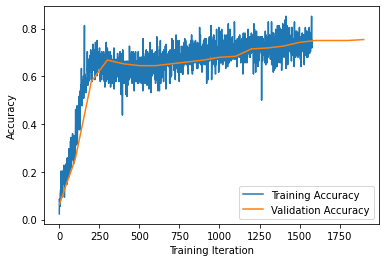

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()